In [1]:
import pandas as pd
import numpy as np
# List of file paths
file_paths = [
    "spy_data/spy_2020_rth_data.csv",
    "spy_data/spy_2021_rth_data.csv",
    "spy_data/spy_2022_rth_data.csv",
    "spy_data/spy_2023_rth_data.csv",
]

# List to store the DataFrames
dataframes = []

# For loop to read each file into a DataFrame
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Unnamed: 0'])
    df.set_index('Time', inplace=True)
    dataframes.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dataframes)

# Combine rows with the same index by averaging
# combined_df = combined_df.groupby(combined_df.index).mean()

# Display the first few rows of the combined DataFrame
combined_df.head()


Unnamed: 0     Open     High      Low    Close  \
Time                                                                           
2020-01-02 09:35:00  2020-01-02 09:35:00  303.932  304.297  303.627  303.910   
2020-01-02 09:40:00  2020-01-02 09:40:00  304.096  304.316  303.753  303.929   
2020-01-02 09:45:00  2020-01-02 09:45:00  304.115  304.344  303.697  303.817   
2020-01-02 09:50:00  2020-01-02 09:50:00  303.993  304.185  303.547  303.695   
2020-01-02 09:55:00  2020-01-02 09:55:00  303.889  304.241  303.561  303.929   

                      Volume  
Time                          
2020-01-02 09:35:00  1204856  
2020-01-02 09:40:00   679936  
2020-01-02 09:45:00   746871  
2020-01-02 09:50:00   806887  
2020-01-02 09:55:00   508812

In [2]:
combined_df['Date'] = combined_df.index.date

# Load VIX historical data
vix_data = pd.read_csv('VIX_History.csv')

# Convert the DATE column to datetime
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'])

# Merge SPY and VIX data on Date
merged_data = pd.merge(combined_df, vix_data[['DATE', 'CLOSE']], left_on='Date', right_on=vix_data['DATE'].dt.date, how='left')

# Rename the VIX CLOSE column for clarity
merged_data = merged_data.rename(columns={'CLOSE': 'VIX'})

# Drop the redundant DATE column
merged_data = merged_data.drop(columns=['DATE'])

In [3]:
merged_data['Unnamed: 0'] = pd.to_datetime(merged_data['Unnamed: 0'])
merged_data.set_index('Unnamed: 0', inplace=True)
merged_data.head(82)
# print(len(combined_df))

Open     High      Low    Close   Volume        Date  \
Unnamed: 0                                                                     
2020-01-02 09:35:00  303.932  304.297  303.627  303.910  1204856  2020-01-02   
2020-01-02 09:40:00  304.096  304.316  303.753  303.929   679936  2020-01-02   
2020-01-02 09:45:00  304.115  304.344  303.697  303.817   746871  2020-01-02   
2020-01-02 09:50:00  303.993  304.185  303.547  303.695   806887  2020-01-02   
2020-01-02 09:55:00  303.889  304.241  303.561  303.929   508812  2020-01-02   
...                      ...      ...      ...      ...      ...         ...   
2020-01-02 16:00:00  305.016  305.152  304.607  304.802  2595292  2020-01-02   
2020-01-02 16:05:00  304.988  305.190  304.677  304.896   465511  2020-01-02   
2020-01-02 16:10:00  305.054  305.180  304.677  304.896  1975976  2020-01-02   
2020-01-02 16:15:00  305.035  305.162  304.100  304.877   119260  2020-01-02   
2020-01-03 09:35:00  302.941  303.048  302.262  302.559  1397702  2020-01-03   

                       VIX  
Unnamed: 0                  
2020-01-02 09:35:00  12.47  
2020-01-02 09:40:00  12.47  
2020-01-02 09:45:00  12.47  
2020-01-02 09:50:00  12.47  
2020-01-02 09:55:00  12.47  
...                    ...  
2020-01-02 16:00:00  12.47  
2020-01-02 16:05:00  12.47  
2020-01-02 16:10:00  12.47  
2020-01-02 16:15:00  12.47  
2020-01-03 09:35:00  14.02  

[82 rows x 7 columns]

### calculate average bar range from past ten bars

In [4]:
def calculate_atr(df, period=14):
    # Calculate True Range (TR)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)

    df['previous_close'] = df['Close'].shift(1)
    df['previous_high'] = df['High'].shift(1)
    df['previous_low'] = df['Low'].shift(1)
    df['previous_open'] = df['Open'].shift(1)
    df['tr1'] = df['High'] - df['Low']
    df['tr2'] = abs(df['High'] - df['previous_close'])
    df['tr3'] = abs(df['Low'] - df['previous_close'])
    df['True_Range'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)

    # Calculate ATR
    df['ATR'] = df['True_Range'].rolling(window=period).mean()
    # Calculate ABR
    df['ABR'] = df['tr1'].shift(1).rolling(window=10).mean()
    # Calculate bar overlap
    df['overlap_high'] = np.minimum(df['High'], df['previous_high'])
    df['overlap_low'] = np.maximum(df['Low'], df['previous_low'])
    df['non_overlap'] = np.maximum((df['overlap_low'] - df['Low']), (df['High'] - df['overlap_high']))
    
        # creating feature
    df['close_diff'] = (df['Close'] - df['previous_close']) * 10
    df['high_diff'] = (df['High'] - df['previous_high']) * 10
    df['low_diff'] = (df['Low'] - df['previous_low']) * 10
    df['open_diff'] = (df['Open'] - df['previous_open']) * 10
    return df

atr_df = calculate_atr(merged_data)

# Display the DataFrame with ATR
print(atr_df.head(15))

                        Open     High      Low    Close   Volume        Date  \
Unnamed: 0                                                                     
2020-01-02 09:35:00  303.932  304.297  303.627  303.910  1204856  2020-01-02   
2020-01-02 09:40:00  304.096  304.316  303.753  303.929   679936  2020-01-02   
2020-01-02 09:45:00  304.115  304.344  303.697  303.817   746871  2020-01-02   
2020-01-02 09:50:00  303.993  304.185  303.547  303.695   806887  2020-01-02   
2020-01-02 09:55:00  303.889  304.241  303.561  303.929   508812  2020-01-02   
2020-01-02 10:00:00  304.115  304.222  303.462  303.638   517760  2020-01-02   
2020-01-02 10:05:00  303.824  303.959  303.472  303.648   308746  2020-01-02   
2020-01-02 10:10:00  303.833  303.969  303.097  303.225   801278  2020-01-02   
2020-01-02 10:15:00  303.411  303.490  302.740  303.042   906703  2020-01-02   
2020-01-02 10:20:00  303.223  303.330  302.646  302.925   597518  2020-01-02   
2020-01-02 10:25:00  303.110  303.396  3

In [5]:
print(atr_df.head(50))

                        Open     High      Low    Close   Volume        Date  \
Unnamed: 0                                                                     
2020-01-02 09:35:00  303.932  304.297  303.627  303.910  1204856  2020-01-02   
2020-01-02 09:40:00  304.096  304.316  303.753  303.929   679936  2020-01-02   
2020-01-02 09:45:00  304.115  304.344  303.697  303.817   746871  2020-01-02   
2020-01-02 09:50:00  303.993  304.185  303.547  303.695   806887  2020-01-02   
2020-01-02 09:55:00  303.889  304.241  303.561  303.929   508812  2020-01-02   
2020-01-02 10:00:00  304.115  304.222  303.462  303.638   517760  2020-01-02   
2020-01-02 10:05:00  303.824  303.959  303.472  303.648   308746  2020-01-02   
2020-01-02 10:10:00  303.833  303.969  303.097  303.225   801278  2020-01-02   
2020-01-02 10:15:00  303.411  303.490  302.740  303.042   906703  2020-01-02   
2020-01-02 10:20:00  303.223  303.330  302.646  302.925   597518  2020-01-02   
2020-01-02 10:25:00  303.110  303.396  3

In [6]:
atr_df["Open"] = atr_df["Open"].astype(float)
atr_df["High"] = atr_df["High"].astype(float)
atr_df["Low"] = atr_df["Low"].astype(float)
atr_df["Close"] = atr_df["Close"].astype(float)
atr_df["ATR"] = atr_df["ATR"].astype(float)
atr_df["ABR"] = atr_df["ABR"].astype(float)
atr_df["non_overlap"] = atr_df["non_overlap"].astype(float)
# atr_df["Volume"] = atr_df["Volume"].astype(float)
# Filter the data for May 2024
may_df = atr_df[atr_df.index.month == 5]

print(may_df.head(50))

                        Open     High      Low    Close   Volume        Date  \
Unnamed: 0                                                                     
2020-05-01 09:35:00  270.054  270.160  268.744  268.850  2125352  2020-05-01   
2020-05-01 09:40:00  268.940  269.244  268.583  268.911  2308775  2020-05-01   
2020-05-01 09:45:00  269.072  269.366  268.727  269.209  1329097  2020-05-01   
2020-05-01 09:50:00  269.280  269.447  268.461  268.652  2070335  2020-05-01   
2020-05-01 09:55:00  268.732  269.376  268.565  269.162  2032490  2020-05-01   
2020-05-01 10:00:00  269.242  270.132  268.829  269.520  1987430  2020-05-01   
2020-05-01 10:05:00  269.601  270.065  269.254  269.472   959748  2020-05-01   
2020-05-01 10:10:00  269.544  269.621  268.688  269.114  1700105  2020-05-01   
2020-05-01 10:15:00  269.167  269.423  268.432  268.604   961508  2020-05-01   
2020-05-01 10:20:00  268.657  268.932  268.215  268.485  1574826  2020-05-01   
2020-05-01 10:25:00  268.548  269.319  2

In [7]:
# List of columns to drop
columns_to_drop = ['previous_close', 'tr2', 'tr3', 'True_Range']

# Drop the columns
atr_df = atr_df.drop(columns=columns_to_drop)

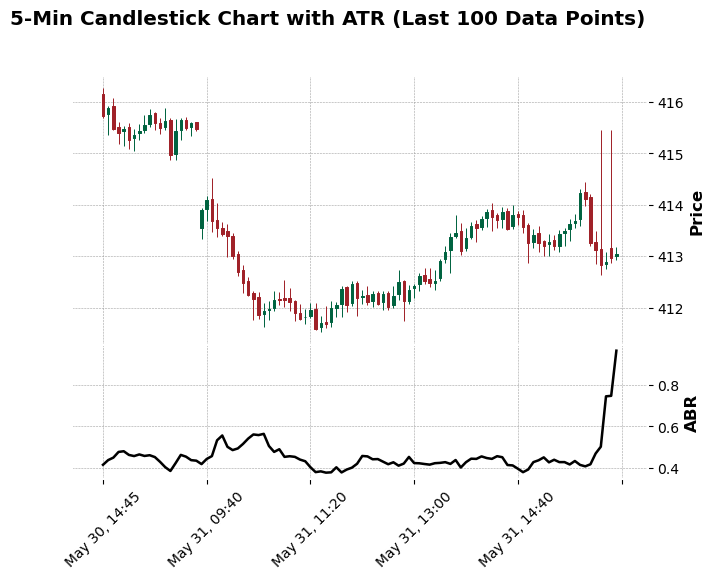

In [8]:
import mplfinance as mpf

last_100_df = may_df.tail(100)

# Prepare the DataFrame for mplfinance
last_100_df = last_100_df[['Open', 'High', 'Low', 'Close', 'ATR', 'ABR']]

# Plot the candlestick chart with ATR for the last 100 data points
apd = [mpf.make_addplot(last_100_df['ATR'], panel=1, color='blue', ylabel='ATR'), mpf.make_addplot(last_100_df['ABR'], panel=1, color='k', ylabel='ABR')]
mpf.plot(last_100_df, type='candle', style='charles', addplot=apd[1], title=f'5-Min Candlestick Chart with ATR (Last 100 Data Points)', ylabel='Price', panel_ratios=(2, 1))

### label and highlight the data

In [9]:
import pandas as pd
df = pd.DataFrame(atr_df)
if 'label' not in df.columns:
    df['label'] = 0
if 'highlight' not in df.columns:
    df['highlight'] = False
    
print(df.head(10))
print(len(df))
for idx, row in enumerate(df.itertuples(index=True, name='Pandas')):
    # print(f"Before updating label: Index {row.Index}, Label {atr_df.at[row.Index, 'label']}")
    # atr_df.at[row.Index, 'label'] = 1.0
    # print(f"After updating label: Index {row.Index}, Label {atr_df.at[row.Index, 'label']}")

    if idx == 0:
        df.at[row.Index, 'close_diff'] = 0
        df.at[row.Index, 'high_diff'] = 0
        df.at[row.Index, 'low_diff'] = 0
        df.at[row.Index, 'open_diff'] = 0
        
    if pd.isna(row.ATR):
        df.at[row.Index, 'label'] = 0
        # print(row.Index, row.Open, row.High, row.Low, row.Close, row.ATR, row.label)
        continue
    # highlight the large bar
    if pd.isna(row.ABR) or row.tr1 < 1.05* row.ABR or row.non_overlap < 0.4*row.tr1:
        df.at[row.Index, 'highlight'] = False
        df.at[row.Index, 'label'] = 0
    
    elif row.tr1 >= 1.05*row.ABR and row.non_overlap >= 0.4*row.tr1:
        df.at[row.Index, 'highlight'] = True
        
    two_atr = row.ATR * 1.0
    pos_target = row.Close + two_atr
    neg_target = row.Close - two_atr

    label = 0
    # Get the close price of the next row
    for i in range(1, (len(df) - idx)):
        next_row = df.iloc[idx + i]
        if next_row.High >= pos_target and next_row.Low <= neg_target:
            if next_row.Close > next_row.Open:
                label = 1
            elif next_row.Close < next_row.Open:
                label = -1
            break
        elif next_row.High >= pos_target:
            label = 1
            break
        elif next_row.Low <= neg_target:
            label = -1
            break
    df.at[row.Index, 'label'] = label
    # print(row.Index, row.Open, row.High, row.Low, row.Close, row.ATR, row.label)
print("after change")
print(df.head(10))

                        Open     High      Low    Close   Volume        Date  \
Unnamed: 0                                                                     
2020-01-02 09:35:00  303.932  304.297  303.627  303.910  1204856  2020-01-02   
2020-01-02 09:40:00  304.096  304.316  303.753  303.929   679936  2020-01-02   
2020-01-02 09:45:00  304.115  304.344  303.697  303.817   746871  2020-01-02   
2020-01-02 09:50:00  303.993  304.185  303.547  303.695   806887  2020-01-02   
2020-01-02 09:55:00  303.889  304.241  303.561  303.929   508812  2020-01-02   
2020-01-02 10:00:00  304.115  304.222  303.462  303.638   517760  2020-01-02   
2020-01-02 10:05:00  303.824  303.959  303.472  303.648   308746  2020-01-02   
2020-01-02 10:10:00  303.833  303.969  303.097  303.225   801278  2020-01-02   
2020-01-02 10:15:00  303.411  303.490  302.740  303.042   906703  2020-01-02   
2020-01-02 10:20:00  303.223  303.330  302.646  302.925   597518  2020-01-02   

                       VIX  previous_hi

In [10]:
print(df.head(1000))

                        Open     High      Low    Close   Volume        Date  \
Unnamed: 0                                                                     
2020-01-02 09:35:00  303.932  304.297  303.627  303.910  1204856  2020-01-02   
2020-01-02 09:40:00  304.096  304.316  303.753  303.929   679936  2020-01-02   
2020-01-02 09:45:00  304.115  304.344  303.697  303.817   746871  2020-01-02   
2020-01-02 09:50:00  303.993  304.185  303.547  303.695   806887  2020-01-02   
2020-01-02 09:55:00  303.889  304.241  303.561  303.929   508812  2020-01-02   
...                      ...      ...      ...      ...      ...         ...   
2020-01-21 11:30:00  311.509  311.699  311.207  311.338   287676  2020-01-21   
2020-01-21 11:35:00  311.526  311.699  311.202  311.418   191309  2020-01-21   
2020-01-21 11:40:00  311.608  311.887  311.296  311.512   676070  2020-01-21   
2020-01-21 11:45:00  311.711  311.849  311.361  311.521   628256  2020-01-21   
2020-01-21 11:50:00  311.711  311.858  3

In [11]:
print("\nRows where the label is -1:")
rows_with_label_0 = df[df['label'] == 1]
print(len(rows_with_label_0))


Rows where the label is -1:
42709


### preparing data

In [104]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader

# # Assuming df is your DataFrame with OHLC data, 'Date' column, and 'label' column
# df['Date'] = pd.to_datetime(df['Unnamed: 0'])
# df = df.set_index('Date')

# Create sequences of past twenty days' OHLC data
sequence_length = 60

# Prepare the input features and labels
features = []
labels = []
dates = []
highlights = []

for i in range(len(df) - sequence_length):
    features.append(df[['open_diff', 'high_diff', 'low_diff', 'close_diff']].iloc[i:i + sequence_length].values)
    labels.append(df['label'].iloc[i + sequence_length])
    dates.append(df.index[i + sequence_length])
    highlights.append(df['highlight'].iloc[i + sequence_length])

features = np.array(features)
labels = np.array(labels)
dates = np.array(dates)
highlights = np.array(highlights)

# Normalize the features within each data point using Standard Scaler
scaler = MinMaxScaler()
for i in range(features.shape[0]):
    features[i] = scaler.fit_transform(features[i])
# store the original labels for later use
all_labels = labels
# Convert -1 labels to 0 for binary classification
labels = np.where(labels == -1, 0, 1)

# Convert to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)



In [105]:
print(features[:5])

tensor([[[0.5919, 0.5834, 0.6386, 0.6009],
         [0.8219, 0.6066, 0.8215, 0.6278],
         [0.6185, 0.6175, 0.5573, 0.4418],
         ...,
         [0.6508, 0.7722, 0.7881, 0.8409],
         [0.8219, 0.6468, 0.8157, 0.5739],
         [0.5792, 0.5371, 0.6386, 0.6009]],

        [[0.8219, 0.6066, 0.8215, 0.6278],
         [0.6185, 0.6175, 0.5573, 0.4418],
         [0.4208, 0.3898, 0.4209, 0.4276],
         ...,
         [0.8219, 0.6468, 0.8157, 0.5739],
         [0.5792, 0.5371, 0.6386, 0.6009],
         [0.5919, 0.6760, 0.6792, 0.6406]],

        [[0.6185, 0.6175, 0.5573, 0.4418],
         [0.4208, 0.3898, 0.4209, 0.4276],
         [0.4460, 0.6516, 0.6589, 0.9332],
         ...,
         [0.5792, 0.5371, 0.6386, 0.6009],
         [0.5919, 0.6760, 0.6792, 0.6406],
         [0.6311, 0.7893, 0.6792, 0.9276]],

        [[0.4208, 0.3898, 0.4209, 0.4276],
         [0.4460, 0.6516, 0.6589, 0.9332],
         [0.9088, 0.5603, 0.4949, 0.1875],
         ...,
         [0.5919, 0.6760, 0.6792, 0

In [106]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

dataset = TimeSeriesDataset(features, labels)

In [107]:
# # Split the data
# train_size = int(1.0 * len(dataset))
# test_size = len(dataset) - train_size

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# # Create DataLoader for testing set
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [108]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [109]:
print(features[0])

tensor([[0.5919, 0.5834, 0.6386, 0.6009],
        [0.8219, 0.6066, 0.8215, 0.6278],
        [0.6185, 0.6175, 0.5573, 0.4418],
        [0.4208, 0.3898, 0.4209, 0.4276],
        [0.4460, 0.6516, 0.6589, 0.9332],
        [0.9088, 0.5603, 0.4949, 0.1875],
        [0.1837, 0.2631, 0.6531, 0.6151],
        [0.6045, 0.5956, 0.0943, 0.0000],
        [0.0000, 0.0000, 0.1205, 0.3409],
        [0.3282, 0.3886, 0.5022, 0.4347],
        [0.4334, 0.6638, 0.7213, 0.8949],
        [0.8682, 0.6066, 0.7605, 0.5341],
        [0.5400, 0.5030, 0.5138, 0.3338],
        [0.3156, 0.5262, 0.6618, 0.7812],
        [0.7756, 0.6516, 0.5907, 0.5000],
        [0.4867, 0.5566, 0.7605, 0.7614],
        [0.7630, 1.0000, 0.8970, 1.0000],
        [1.0000, 0.6175, 1.0000, 0.5483],
        [0.5386, 0.5603, 0.5907, 0.7074],
        [0.6844, 0.6175, 0.7750, 0.6804],
        [0.6718, 0.5725, 0.4485, 0.3480],
        [0.3282, 0.5432, 0.6647, 0.8068],
        [0.8022, 0.5895, 0.6386, 0.4077],
        [0.4208, 0.4227, 0.0000, 0

### building LSTM model

In [110]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=2):
        super().__init__()
        self.input_projection = nn.Linear(4, hidden_dim // 4)
        self.act = nn.ReLU()
        self.r = nn.LSTM(hidden_dim // 4, hidden_dim, num_layers, batch_first=True, bidirectional=False, dropout=0.1)
        self.l = nn.Linear(1*num_layers*hidden_dim, 1)
        self.init_weights()

    def init_weights(self):
        for name, param in self.r.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.act(self.input_projection(x))
        lstm_out, (h_n, c_n) = self.r(x) # initial state 
        x = h_n.permute(1, 0, 2).flatten(1)
        x = self.l(x)
        return x

# input_size = 4
# hidden_size = 128  # Adjust as necessary
# num_layers = 2
# output_size = 1
# mlp_output_size = 32
# dropout_prob = 0.1

model = LSTMModel(128).to(device)

In [111]:
import pandas as pd
import numpy as np

# Assuming merged_data already includes the necessary data
df['Date'] = pd.to_datetime(df['Date'])
test_indices = np.load('test_indices.npy', allow_pickle=True).tolist()
test_data = df.loc[test_indices]
unique_dates = test_data['Date'].unique()

print(unique_dates)

['2022-02-04T00:00:00.000000000' '2022-02-16T00:00:00.000000000'
 '2022-02-17T00:00:00.000000000' '2022-03-16T00:00:00.000000000'
 '2022-03-21T00:00:00.000000000' '2022-03-24T00:00:00.000000000'
 '2022-04-22T00:00:00.000000000' '2022-07-11T00:00:00.000000000'
 '2022-08-01T00:00:00.000000000' '2022-08-10T00:00:00.000000000'
 '2022-08-25T00:00:00.000000000' '2022-09-13T00:00:00.000000000'
 '2022-09-16T00:00:00.000000000' '2022-10-28T00:00:00.000000000'
 '2022-11-17T00:00:00.000000000' '2022-11-21T00:00:00.000000000'
 '2022-12-06T00:00:00.000000000' '2022-12-07T00:00:00.000000000'
 '2022-12-27T00:00:00.000000000' '2023-01-05T00:00:00.000000000'
 '2023-01-11T00:00:00.000000000' '2023-01-30T00:00:00.000000000'
 '2023-02-14T00:00:00.000000000' '2023-03-01T00:00:00.000000000'
 '2023-03-15T00:00:00.000000000' '2023-03-24T00:00:00.000000000'
 '2023-03-27T00:00:00.000000000' '2023-04-10T00:00:00.000000000'
 '2023-04-19T00:00:00.000000000' '2023-04-24T00:00:00.000000000'
 '2023-08-02T00:00:00.000

In [112]:
import torch.optim as optim

criterion = nn.BCELoss()

val_indices_all = [j for j, (date, highlight) in enumerate(zip(dates, highlights)) if date in test_indices and highlight]
val_subset = torch.utils.data.Subset(dataset, val_indices_all)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
# Hyperparameters
num_epochs = 100
learning_rate = 0.001

years = sorted(set(df.index.year))
results = []
train_indices = []
for i in range(0,2):
    train_year = years[i]
    # Train and test split based on year
    train_indice = [j for j, (date, highlight) in enumerate(zip(dates, highlights)) if (date.year == train_year) and highlight]
    train_indices.extend(train_indice)
    # test_indices = [j for j, date in enumerate(dates) if date.year == test_year]

train_subset = torch.utils.data.Subset(dataset, train_indices)
# test_subset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=False)
# test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Initialize the model, optimizer
model = LSTMModel(128).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_model_state = None
best_val_loss = float('inf')
# Training loop
for epoch in range(num_epochs):
    model.train()
    loss_mean = 0
    for features, labels in train_loader:
        labels = labels.unsqueeze(1).to(device)
        optimizer.zero_grad()
        x = model(features.to(device))
        loss = nn.functional.binary_cross_entropy_with_logits(x, labels)
        loss_mean = loss_mean + loss.item()
        loss.backward()
        optimizer.step()
    print(f"epoch: {epoch} train loss", loss_mean/len(train_loader))

    

    # Making predictions on the test set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            labels = labels.unsqueeze(1).to(device)
            features = features.to(device)
            outputs = model(features)
            loss = nn.functional.binary_cross_entropy_with_logits(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    print(f"epoch: {epoch} val loss", val_loss)


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        torch.save(best_model_state, f"best_lstm_model_{sequence_length}_x10_minmax.pth")
        print(f"New best model found at epoch {epoch} with val loss {val_loss}")

# # Save the best model
# if best_model_state:
#     torch.save(best_model_state, 'best_lstm_model_30.pth')

print(f'Train Year: {train_year}')
# Save the last model
torch.save(model.state_dict(), f"last_lstm_model_{sequence_length}_x10_minmax.pth")
# # Save the model
# torch.save(model.state_dict(), 'lstm_model_2020_30sequence_2filter_5features.pth')
#     # if i == 1:
#     #   torch.save(model.state_dict(), 'lstm_model_2021.pth')
#     # if i == 2:
#     #   torch.save(model.state_dict(), 'lstm_model_2022.pth')
# # Print overall results
# for year, accuracy, precision in results:
#     print(f'Test Year: {year}, Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%')

# # # Save the model
# # torch.save(model.state_dict(), 'lstm_model.pth')

epoch: 0 train loss 0.6930064600567485
epoch: 0 val loss 0.6920579053737499
New best model found at epoch 0 with val loss 0.6920579053737499
epoch: 1 train loss 0.6914641676947128
epoch: 1 val loss 0.6922676739869295
epoch: 2 train loss 0.6914551244225613
epoch: 2 val loss 0.6924433421205591
epoch: 3 train loss 0.6913728062496629
epoch: 3 val loss 0.6925200400529085
epoch: 4 train loss 0.6912626693415087
epoch: 4 val loss 0.6925724700645164
epoch: 5 train loss 0.6911667737849924
epoch: 5 val loss 0.6927062758692989
epoch: 6 train loss 0.6910931343256042
epoch: 6 val loss 0.6929485334290398
epoch: 7 train loss 0.6909334368483965
epoch: 7 val loss 0.6931718212586863
epoch: 8 train loss 0.6908793047417042
epoch: 8 val loss 0.6935282857329758
epoch: 9 train loss 0.690811810105346
epoch: 9 val loss 0.6938066173482824
epoch: 10 train loss 0.6907129315442817
epoch: 10 val loss 0.6941065633738482
epoch: 11 train loss 0.6906480900076932
epoch: 11 val loss 0.6943604526696382
epoch: 12 train loss

In [113]:
print(best_val_loss)

0.6920579053737499


### sample testing data

In [114]:
# import pandas as pd
# import numpy as np

# # Assuming merged_data already includes the necessary data
# df['Date'] = pd.to_datetime(df['Date'])
# merged_data_testing = df[df['Date'] >= pd.to_datetime('2022-01-01')]
# # Calculate the number of samples needed for 50 days based on the given distribution
# total_days = 50
# mid_vix_percentage = 0.71396396
# low_vix_percentage = 0.22409910
# high_vix_percentage = 0.06193694

# mid_vix_days = int(total_days * mid_vix_percentage)
# low_vix_days = int(total_days * low_vix_percentage)
# high_vix_days = int(total_days * high_vix_percentage)

# # Ensure the total number of days sums to 50
# remaining_days = total_days - (mid_vix_days + low_vix_days + high_vix_days)
# if remaining_days > 0:
#     mid_vix_days += remaining_days

# # Sample unique dates for each category
# mid_vix_dates = np.random.choice(
#     merged_data_testing[(merged_data_testing['VIX'] >= 15) & (merged_data_testing['VIX'] < 30)]['Date'].unique(),
#     mid_vix_days,
#     replace=False
# )
# low_vix_dates = np.random.choice(
#     merged_data_testing[merged_data_testing['VIX'] < 15]['Date'].unique(),
#     low_vix_days,
#     replace=False
# )
# high_vix_dates = np.random.choice(
#     merged_data_testing[merged_data_testing['VIX'] >= 30]['Date'].unique(),
#     high_vix_days,
#     replace=False
# )
# # Filter the data for the selected dates
# mid_vix_data_indices = merged_data_testing[merged_data_testing['Date'].isin(mid_vix_dates)].index.tolist()
# low_vix_data_indices = merged_data_testing[merged_data_testing['Date'].isin(low_vix_dates)].index.tolist()
# high_vix_data_indices = merged_data_testing[merged_data_testing['Date'].isin(high_vix_dates)].index.tolist()

# # Combine the indices
# test_indices = mid_vix_data_indices + low_vix_data_indices + high_vix_data_indices

# print(test_indices)


In [128]:
# Load the best model (assuming you have saved the best model during cross-validation)
model.load_state_dict(torch.load(f'last_lstm_model_{sequence_length}_x10_minmax.pth'))
model = model.to(device)
model.eval()

# test_year = 2023
years = sorted(set(df.index.year))
# for i in range(1, 13):
  # Train and test split based on year
test_indices_all = []

for i in range(0,2):
    train_year = years[i]
    # Train and test split based on year
    train_indice = [j for j, (date, highlight) in enumerate(zip(dates, highlights)) if (date.year == train_year) and highlight]
    test_indices_all.extend(train_indice)
    
# test_indices_all = [j for j, (date) in enumerate(dates) if date in test_indices ]
print(test_indices_all)
test_subset = torch.utils.data.Subset(dataset, test_indices_all)

test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

  # Making predictions on the test set
all_predictions = []
test_true_labels = []
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)  # Move features to device
        labels = labels.to(device)  # Move labels to device
        outputs = torch.sigmoid(model(features))
        all_predictions.extend(outputs.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions).flatten()
# all_labels_test = all_labels[test_indices_all]
test_true_labels = np.array(test_true_labels)
test_true_labels = np.where(test_true_labels == 0, -1, 1)
  # Print the maximum value of the predictions for verification
print(all_predictions.max())
print(all_predictions.min())


# Print some sample predictions
# print('Sample Predictions:')
# for i in range(min(10, len(binary_predictions))):
#     print(f'Predicted: {binary_predictions[i]}, Actual: {all_labels_test[i]}')



[15, 20, 21, 69, 92, 100, 115, 183, 258, 264, 289, 338, 345, 378, 380, 455, 507, 588, 636, 641, 663, 688, 831, 850, 956, 993, 1071, 1074, 1098, 1119, 1155, 1175, 1180, 1187, 1212, 1219, 1226, 1236, 1246, 1298, 1307, 1316, 1358, 1389, 1398, 1400, 1402, 1403, 1463, 1479, 1485, 1487, 1491, 1513, 1515, 1540, 1552, 1556, 1575, 1580, 1596, 1613, 1619, 1640, 1655, 1666, 1684, 1715, 1718, 1722, 1724, 1803, 1804, 1813, 1866, 1888, 1892, 1965, 1986, 2018, 2040, 2050, 2127, 2150, 2178, 2208, 2289, 2294, 2329, 2338, 2354, 2426, 2451, 2461, 2507, 2532, 2613, 2616, 2622, 2630, 2632, 2633, 2635, 2636, 2653, 2655, 2656, 2694, 2695, 2696, 2745, 2768, 2769, 2775, 2792, 2800, 2811, 2816, 2829, 2832, 2833, 2842, 2852, 2865, 2866, 2871, 2876, 2893, 2894, 2900, 2909, 2910, 2925, 2927, 2929, 2930, 2933, 2936, 2957, 2960, 2964, 2966, 2967, 2972, 2979, 2984, 2985, 2987, 2989, 3018, 3020, 3029, 3032, 3046, 3051, 3058, 3062, 3066, 3067, 3083, 3093, 3094, 3095, 3107, 3119, 3123, 3124, 3126, 3137, 3139, 3142, 3146

In [129]:
upper = 0.9
lower = 0.1
# binary_predictions = np.where(all_predictions >= upper, 1, np.where(all_predictions <= lower, -1, 0))
binary_predictions = np.where(all_predictions >= 0.5, 1, -1)

train_indices_all = []
for i in range(0,2):
    train_year = years[i]
    # Train and test split based on year
    train_indice = [date for (date, highlight) in zip(dates, highlights) if (date.year == train_year) and highlight]
    train_indices_all.extend(train_indice)
    
test_data = df.loc[train_indices_all]    

# Filter the data for the testing indices
# test_data = df.loc[test_indices]

# Assuming `all_predictions` and `all_labels` are already defined
test_data['Predicted_Label'] = binary_predictions


# evaluate perfomance
counter = 0
correct_counter = 0
true_counter = 0
true_positives_counter = 0
unique_dates = test_data['Date'].unique()
for unique_date in unique_dates:
    # Filter data for the current date
    daily_data = test_data[test_data['Date'] == unique_date]
    for date, row in daily_data.iterrows():
      if(row['highlight']):
        true_counter += 1
        if(row['label'] == 1):
          true_positives_counter += 1
        if (row['Predicted_Label'] == 1 or row['Predicted_Label'] == -1):
          counter += 1
          if row['Predicted_Label'] == row['label']:
            correct_counter += 1
        
      
# Calculate accuracy
#   Calculate precision
# true_positives = np.sum((binary_predictions == 1) & (all_labels_test == 1))
# false_positives = np.sum((binary_predictions == 1) & (all_labels_test != 1))
# true_negatives = np.sum((binary_predictions == -1) & (all_labels_test == -1))
# false_negatives = np.sum((binary_predictions == -1) & (all_labels_test != -1))
# precision = 100 * true_positives / (true_positives + false_positives)
# precision_down = 100 * true_negatives / (true_negatives + false_negatives)
# accuracy = 100 * np.mean(binary_predictions == all_labels_test)
# print(f'Accuracy: {accuracy: .2f}%, Precision: {precision: .2f}%, Precision -1: {precision_down: .2f}%')

accuracy = 100 * correct_counter / counter
distribution = 100 * true_positives_counter / true_counter
print(f'Distribution: {distribution: .2f}%')
print(f'Accuracy: {accuracy: .2f}%')

Distribution:  53.02%
Accuracy:  95.69%


In [126]:
print(sequence_length)

60


In [127]:
print(counter)

print(true_positives_counter)
print(true_counter)

834
420
834


### Ploting

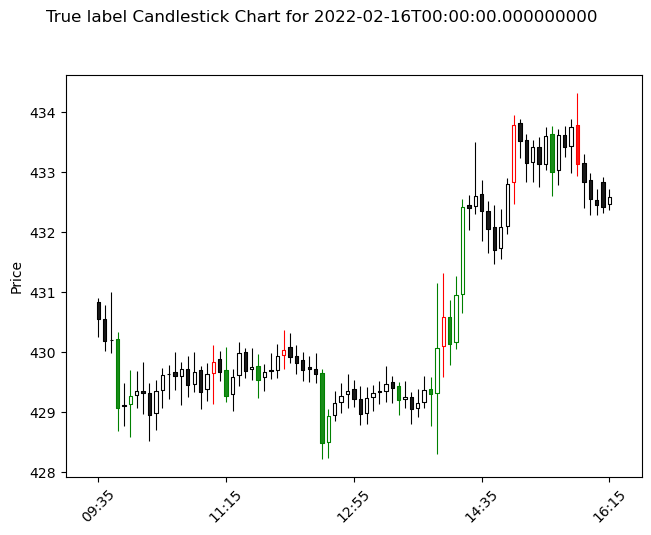

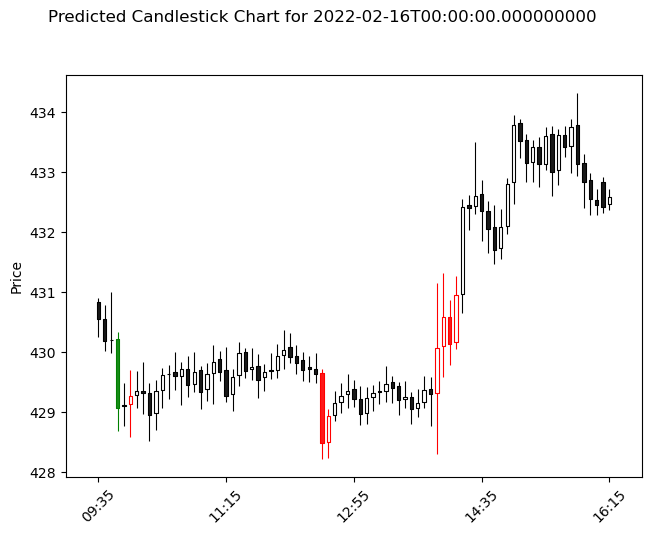

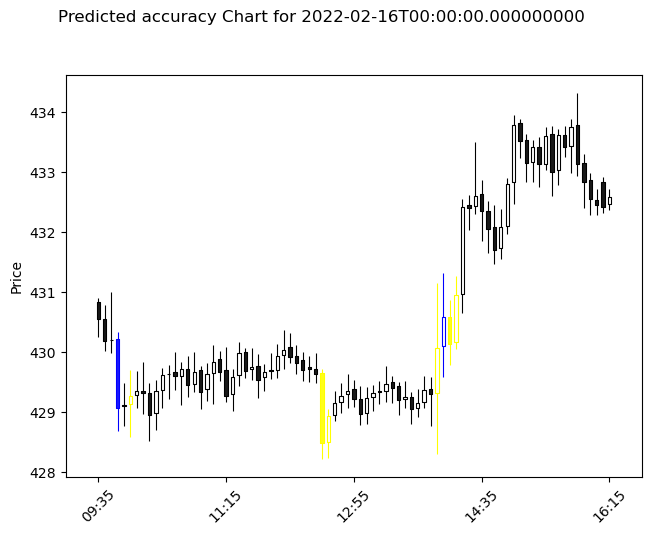

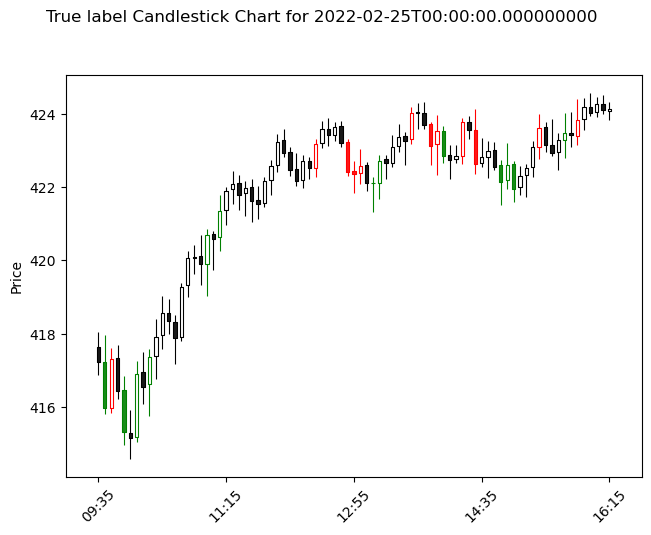

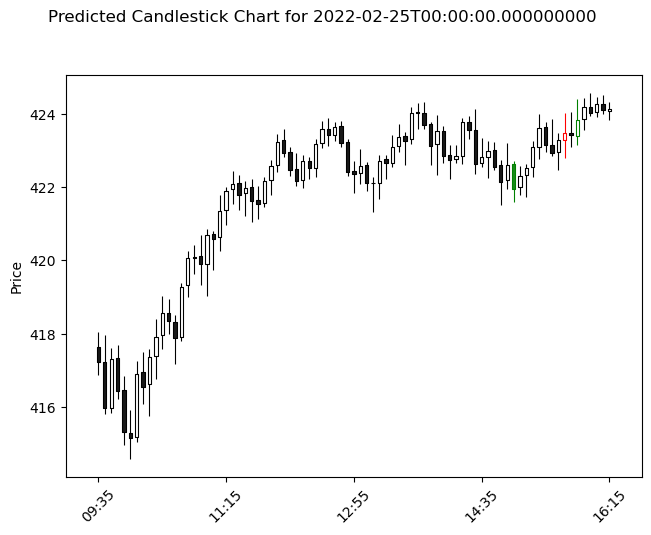

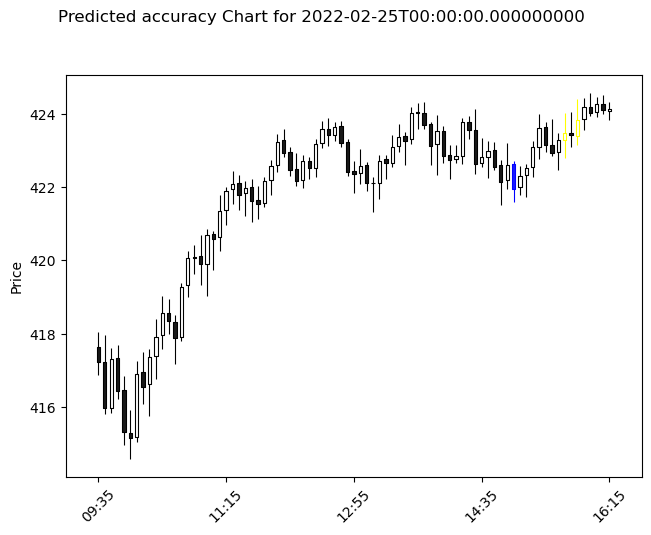

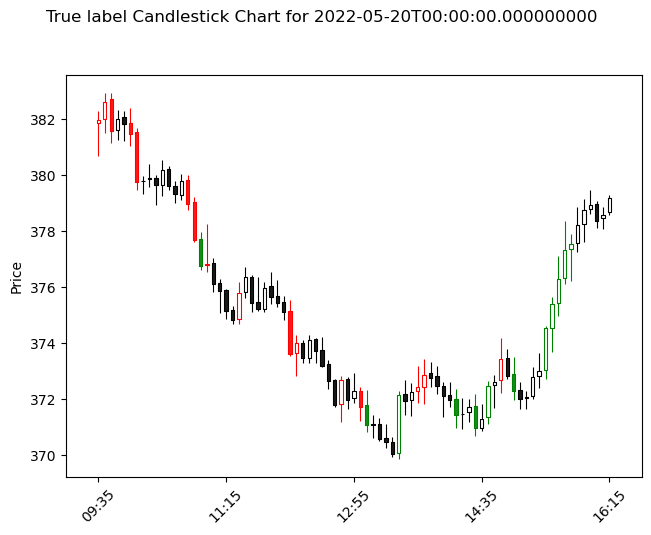

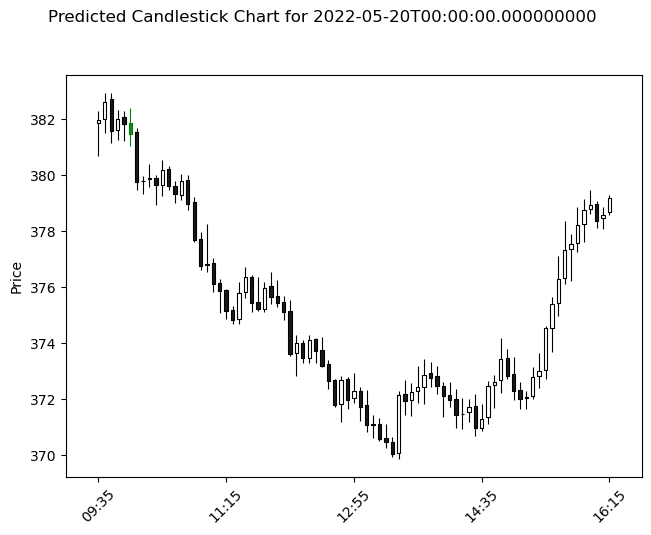

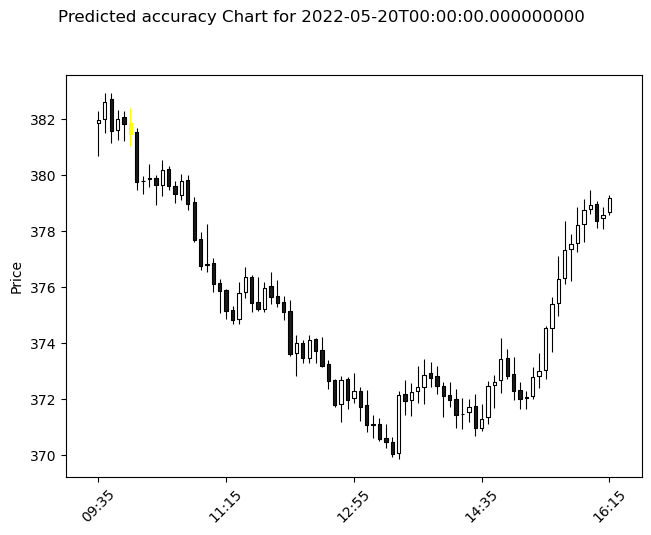

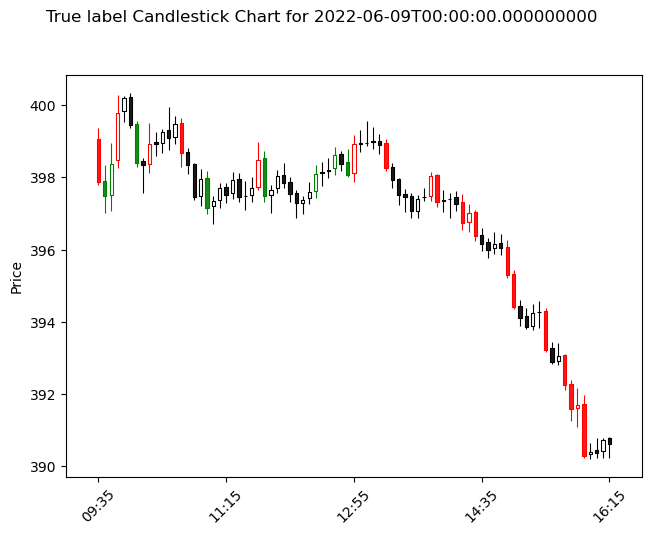

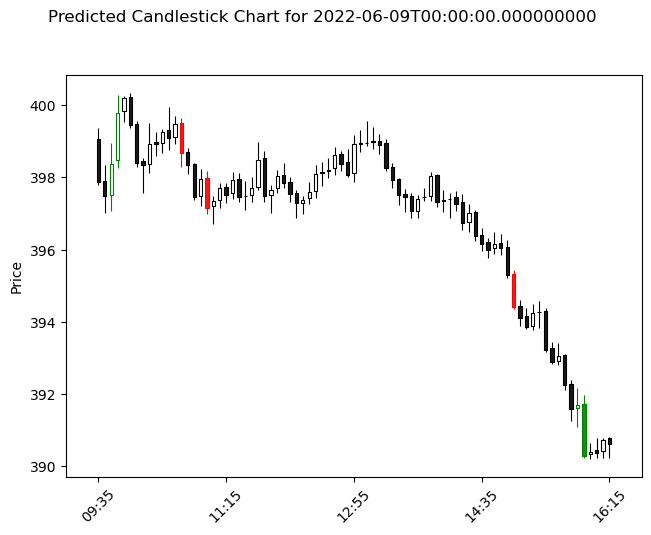

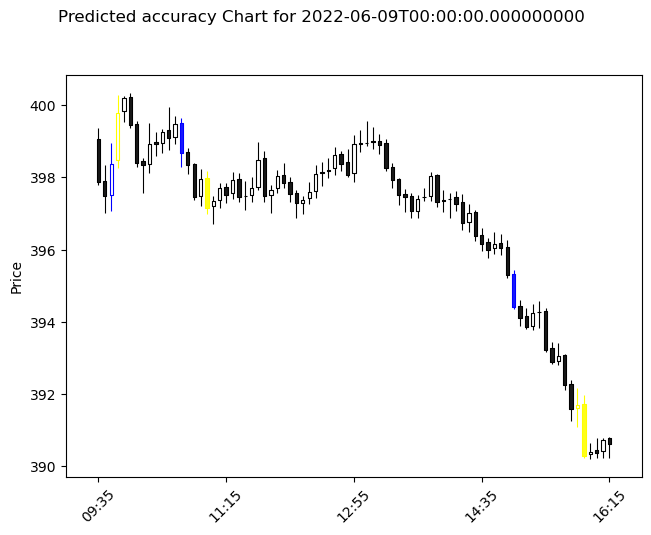

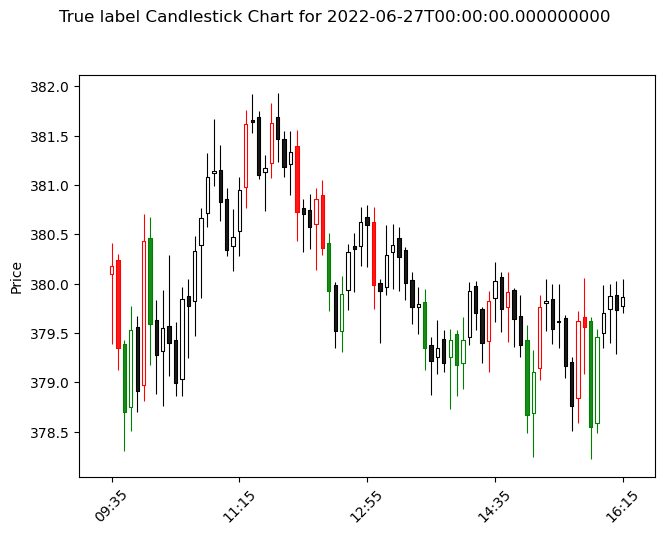

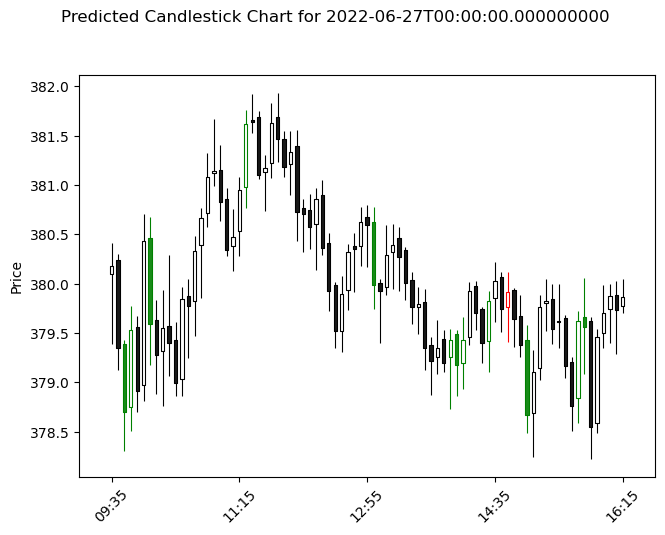

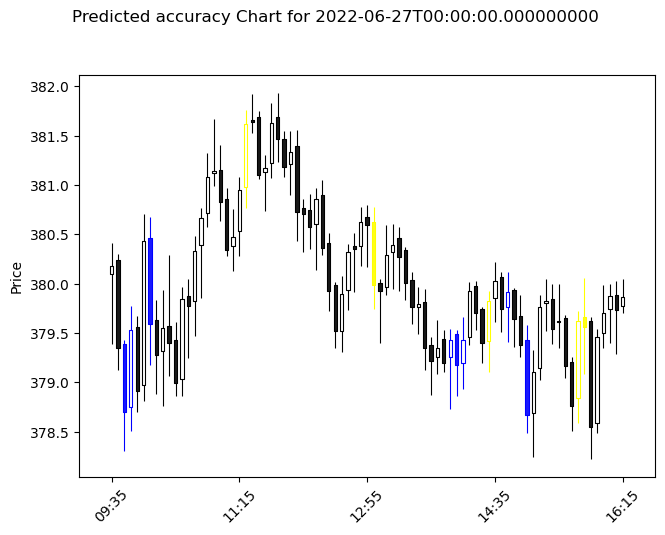

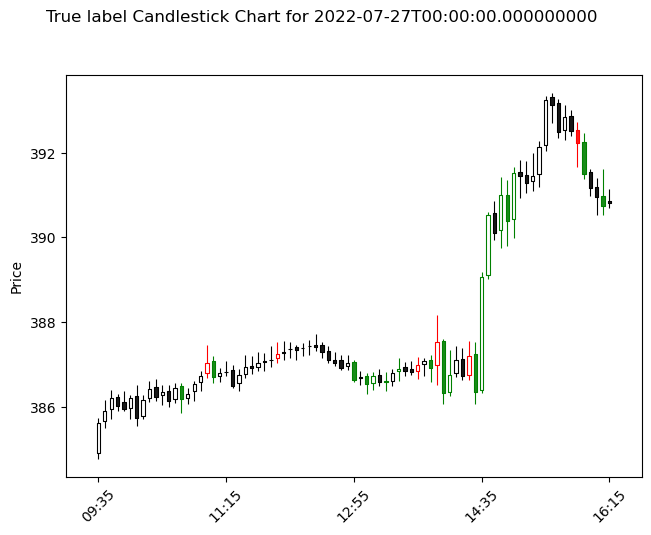

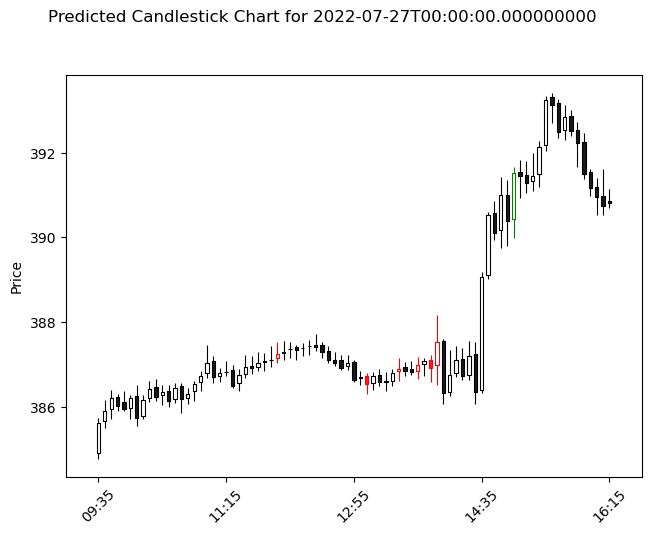

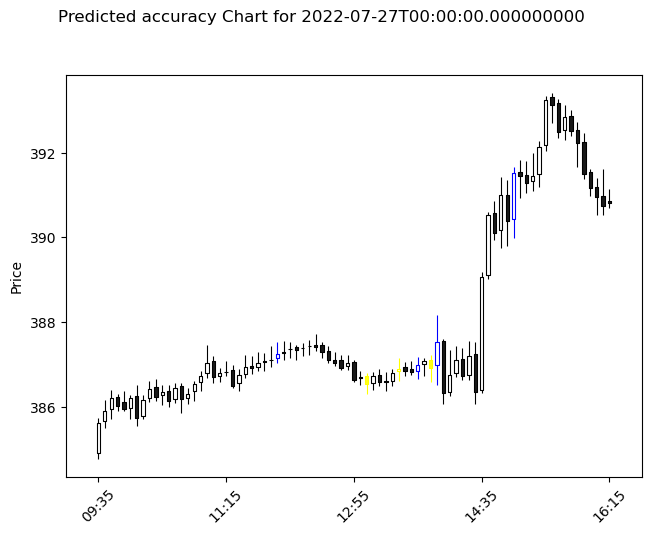

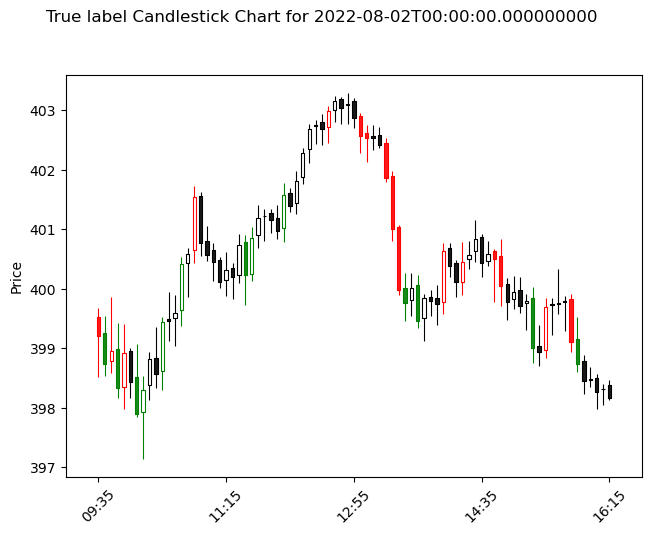

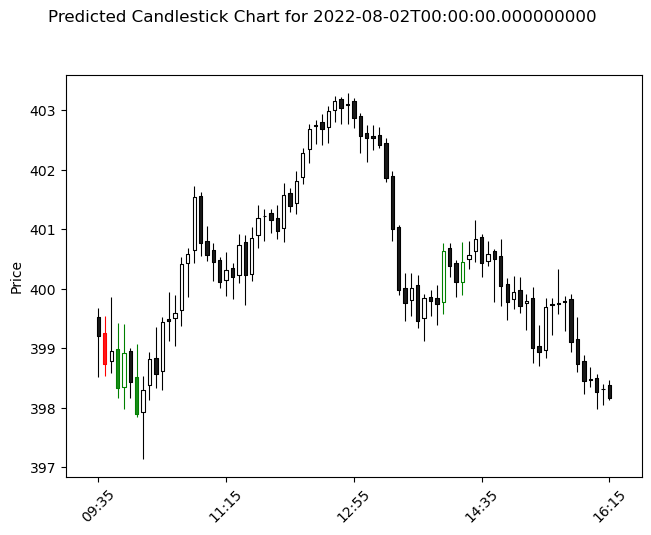

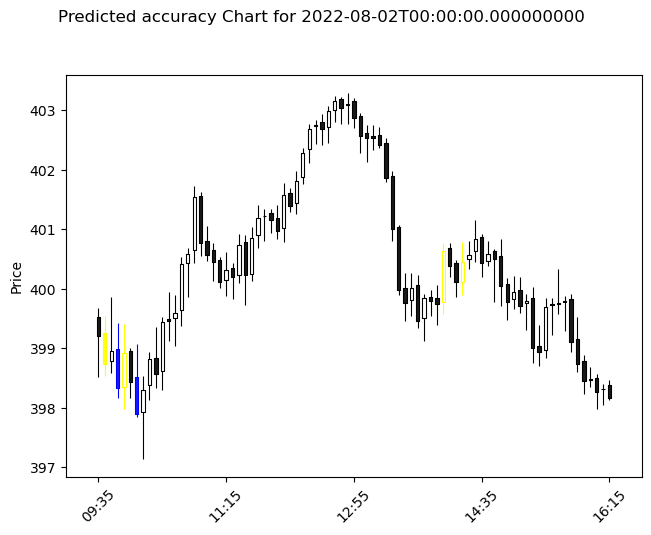

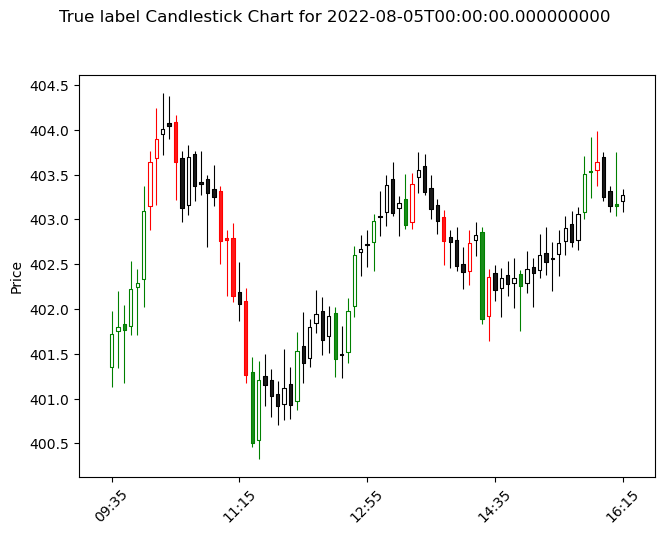

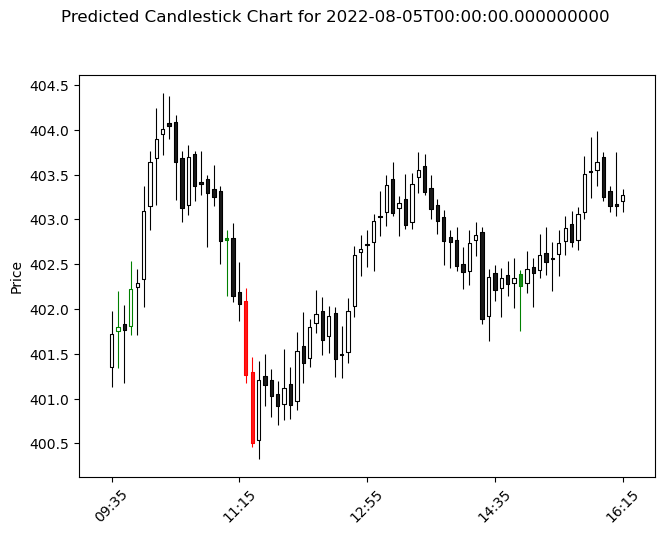

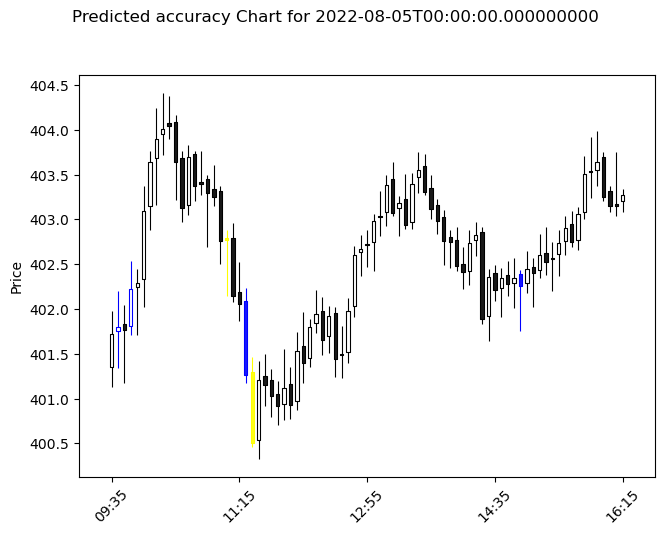

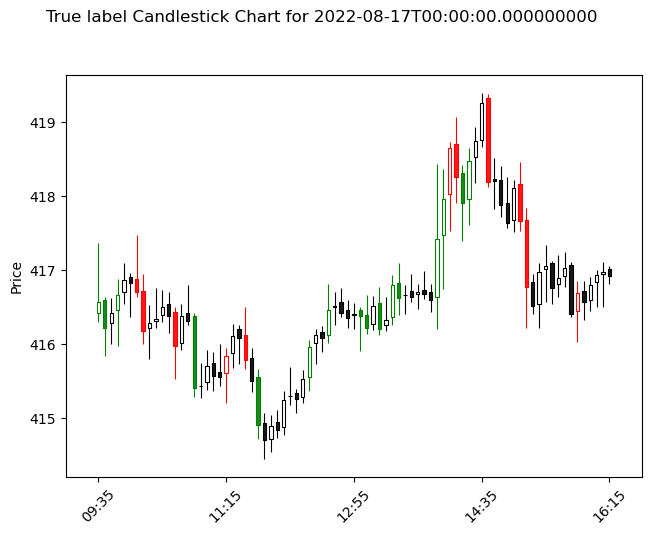

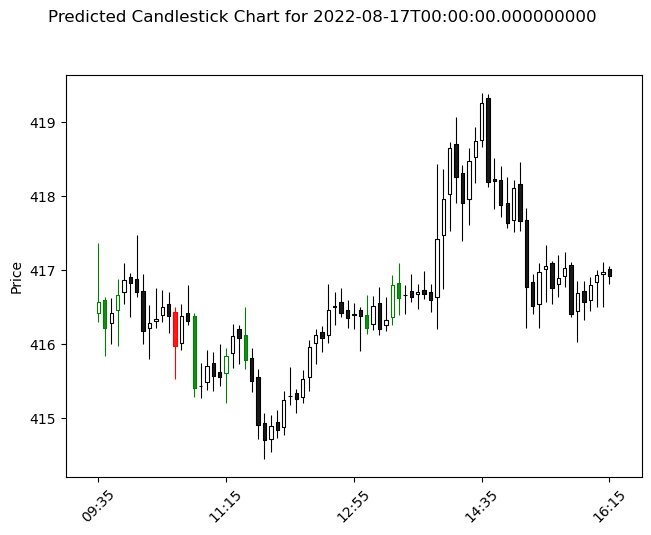

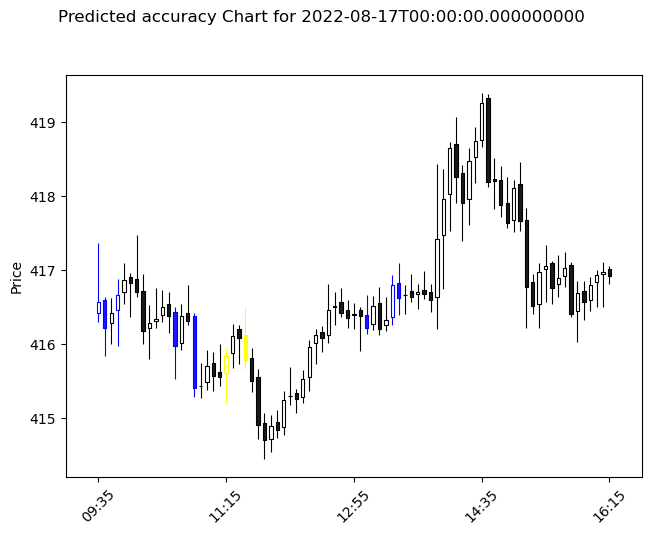

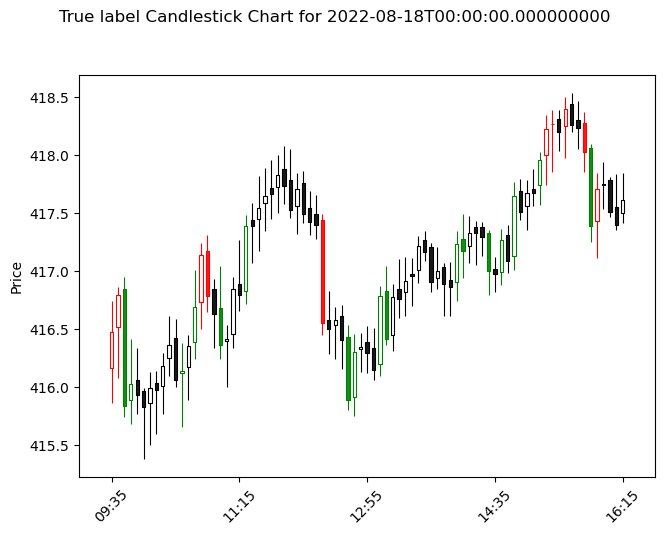

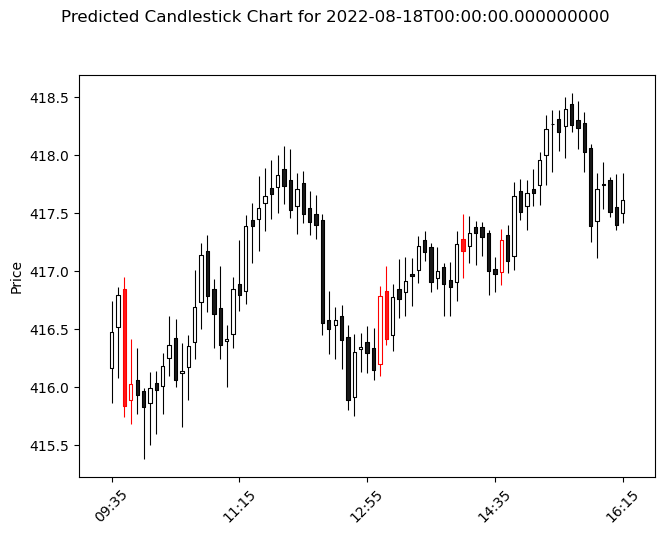

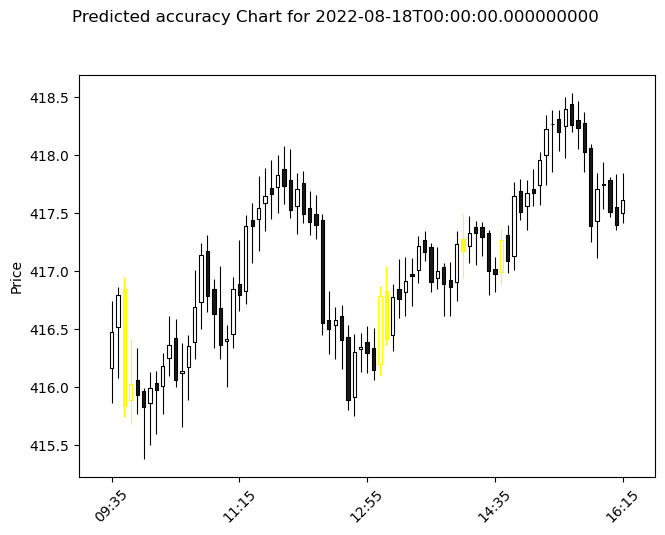

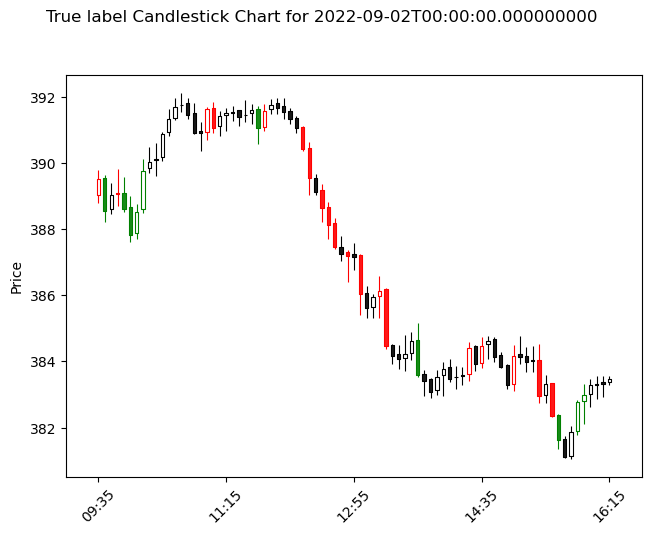

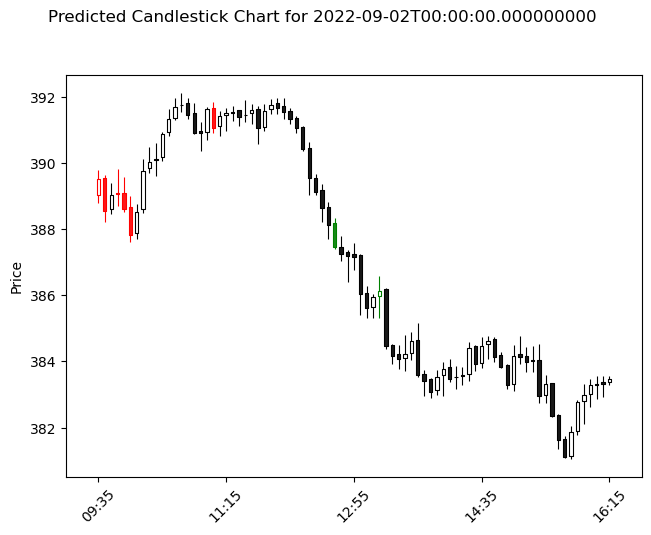

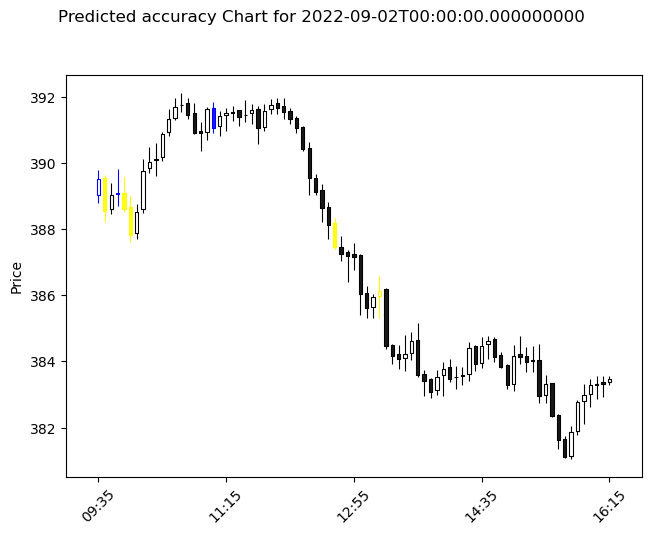

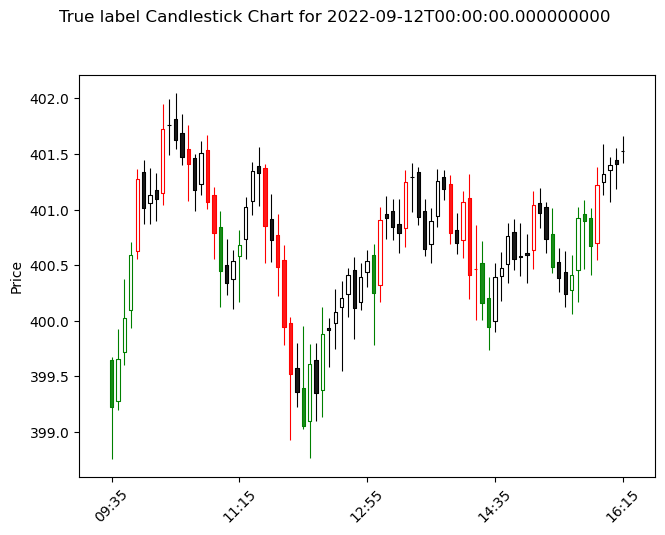

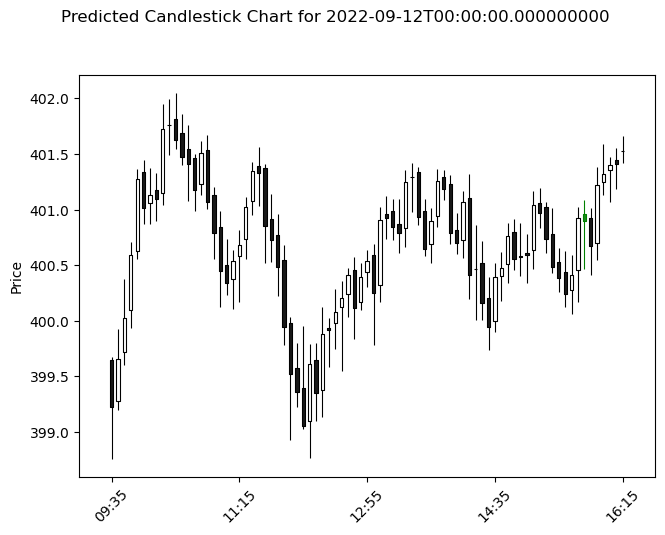

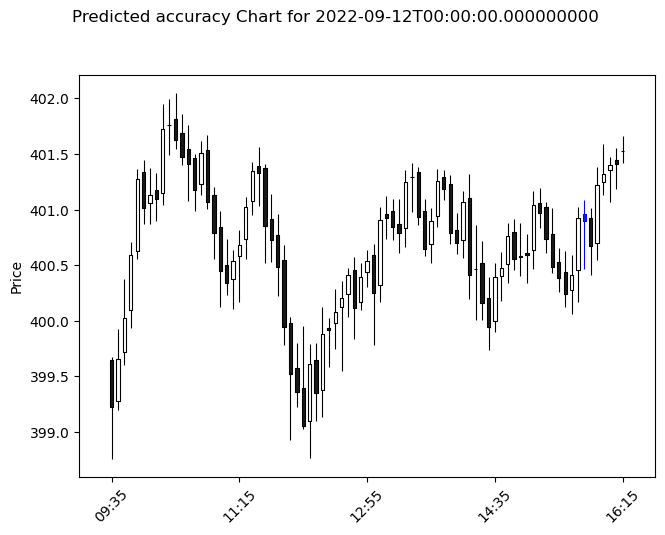

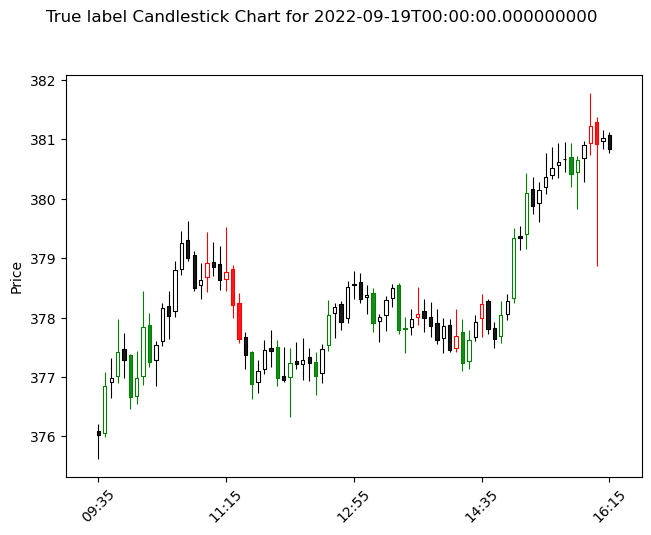

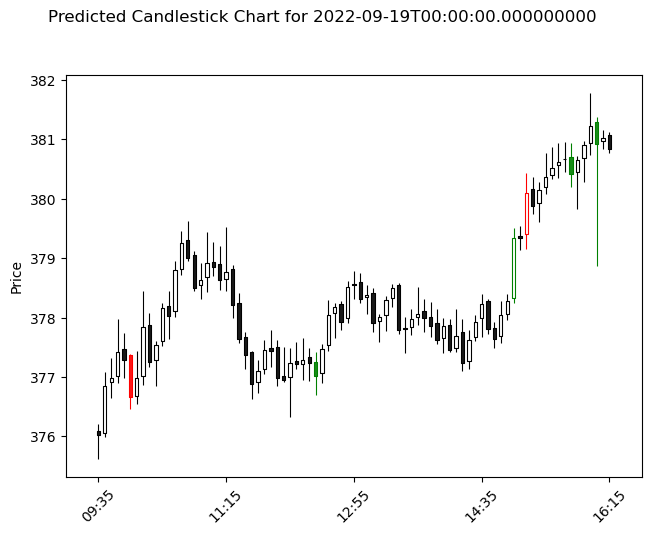

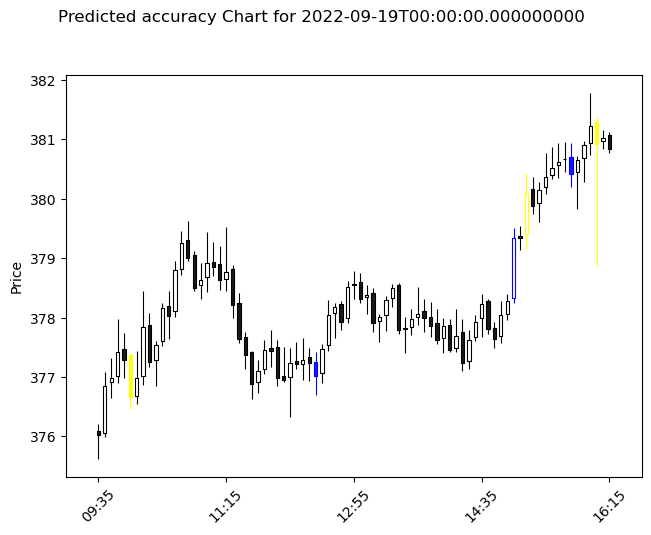

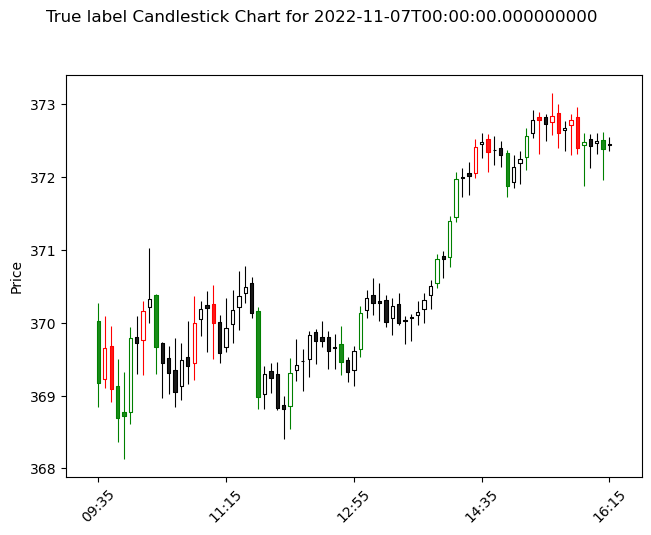

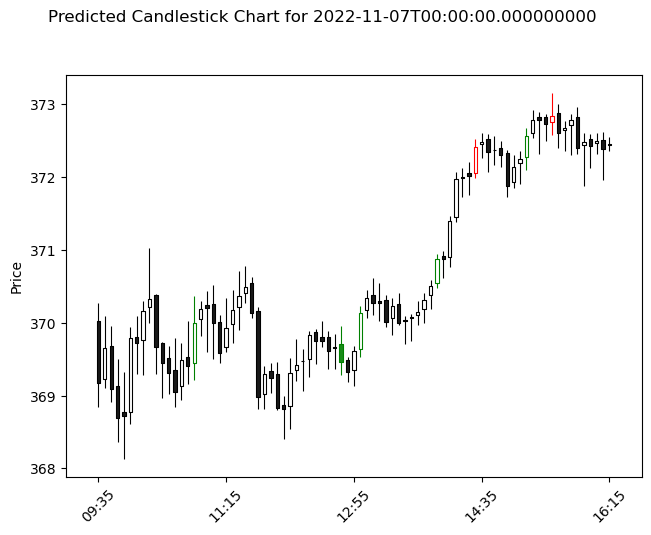

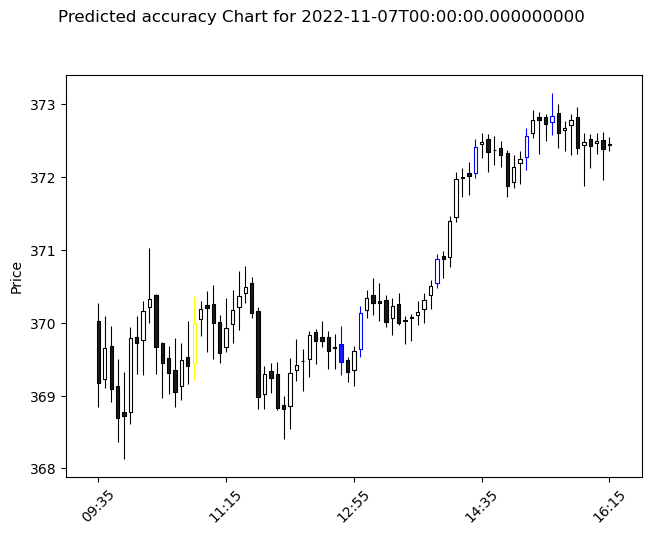

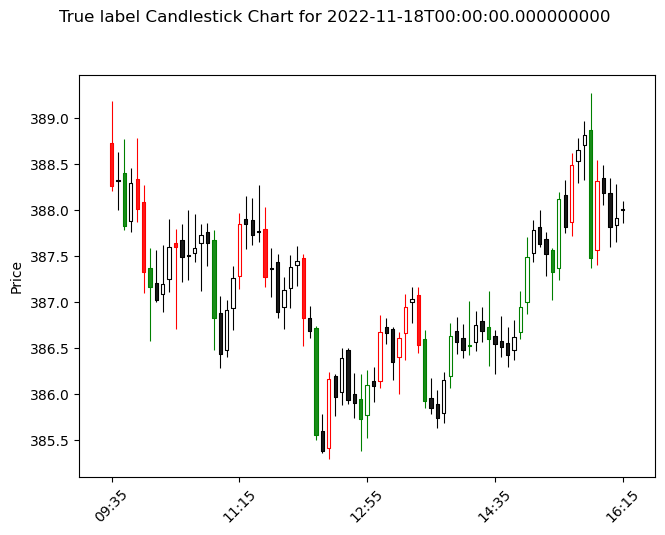

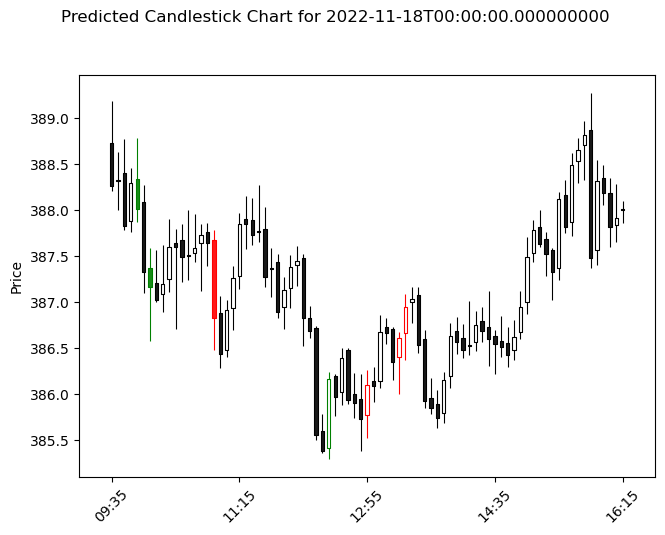

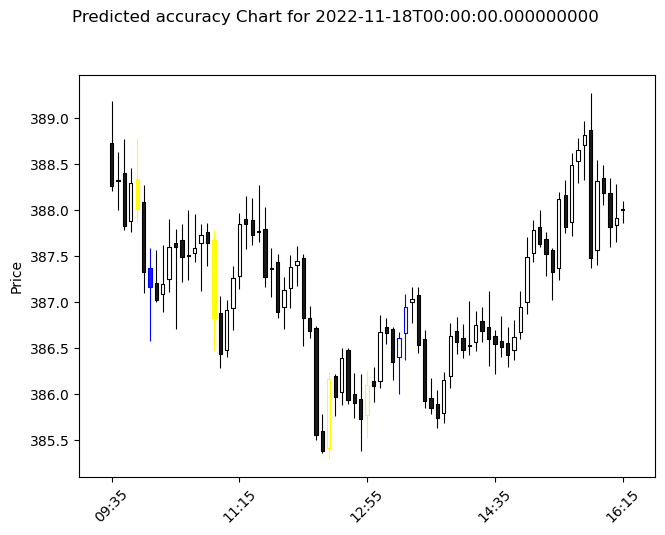

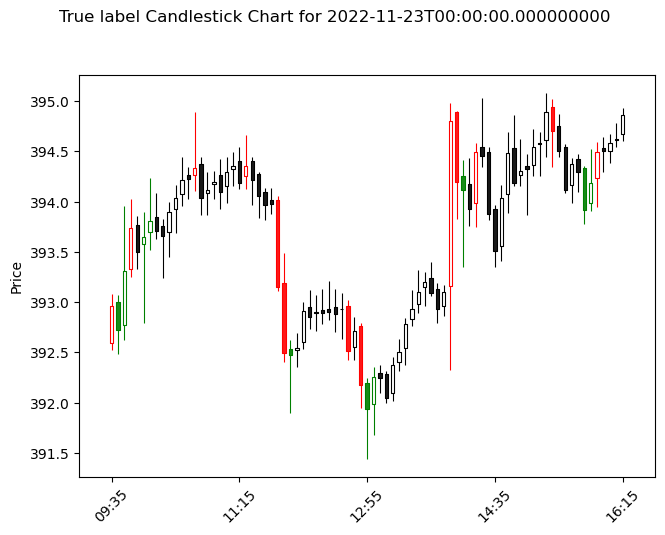

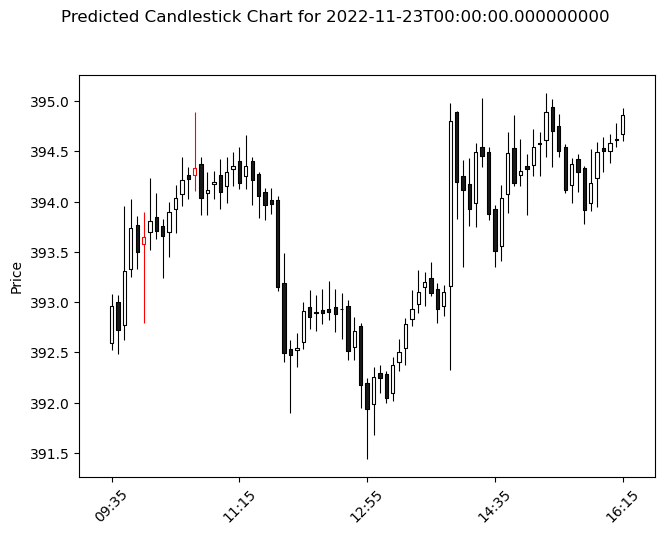

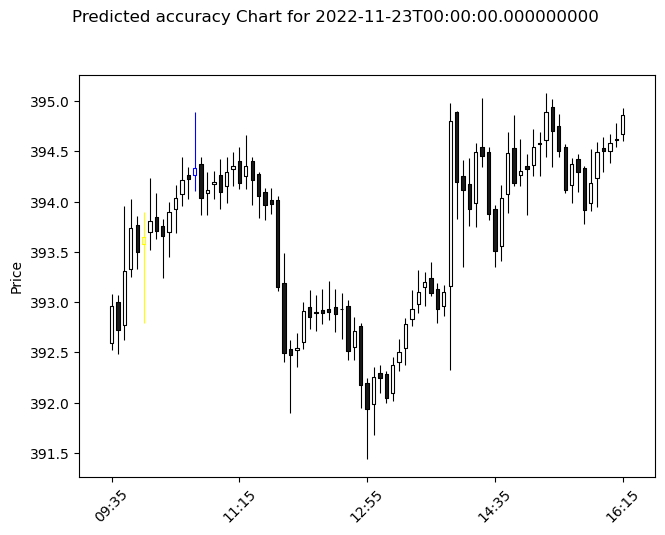

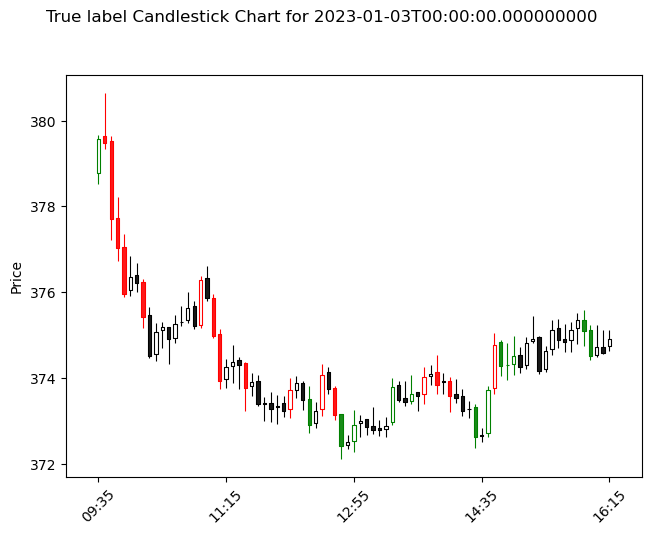

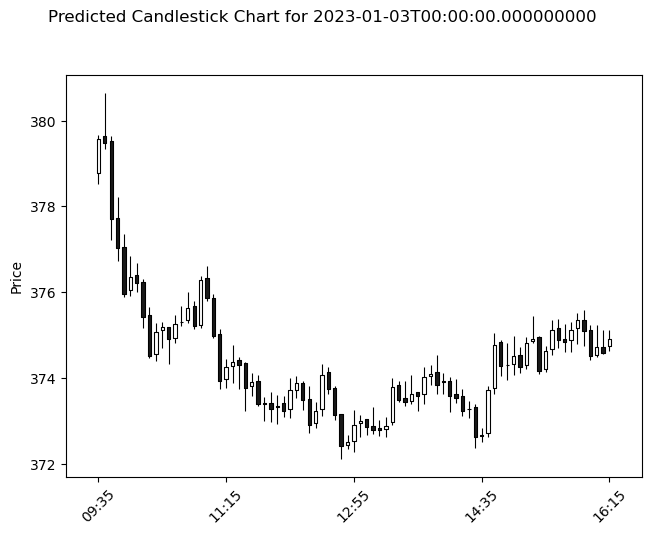

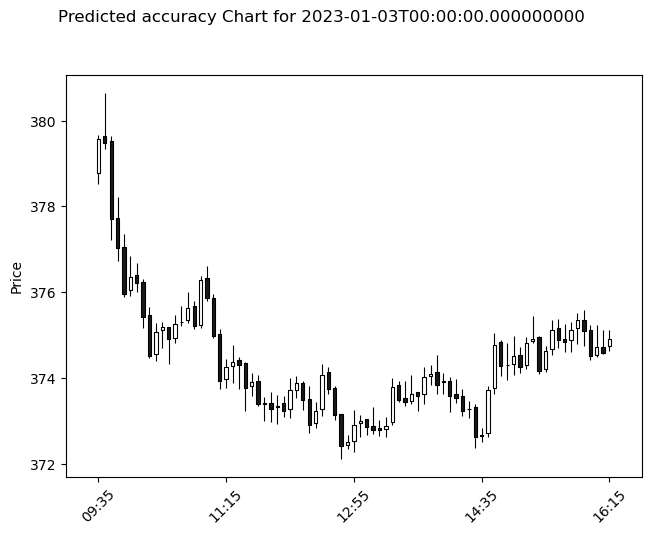

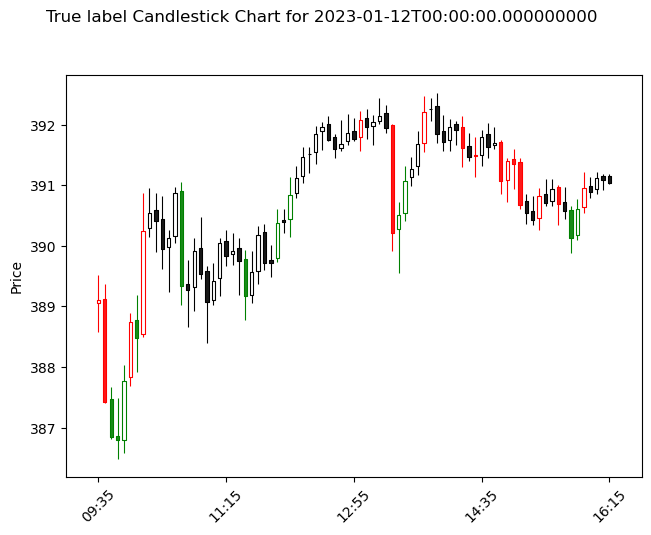

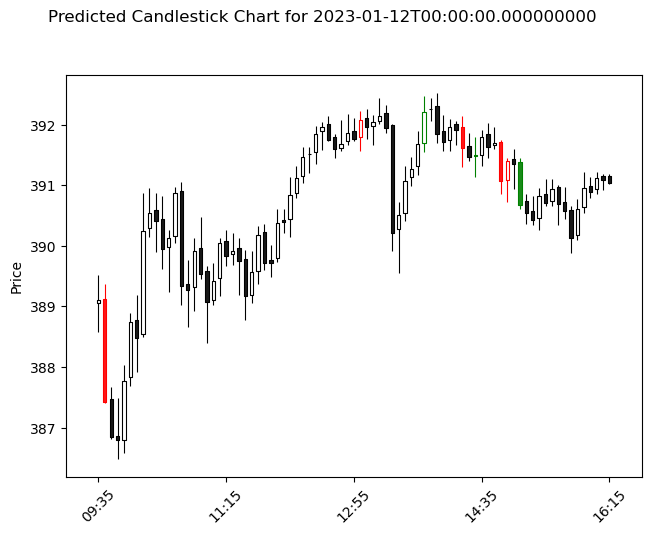

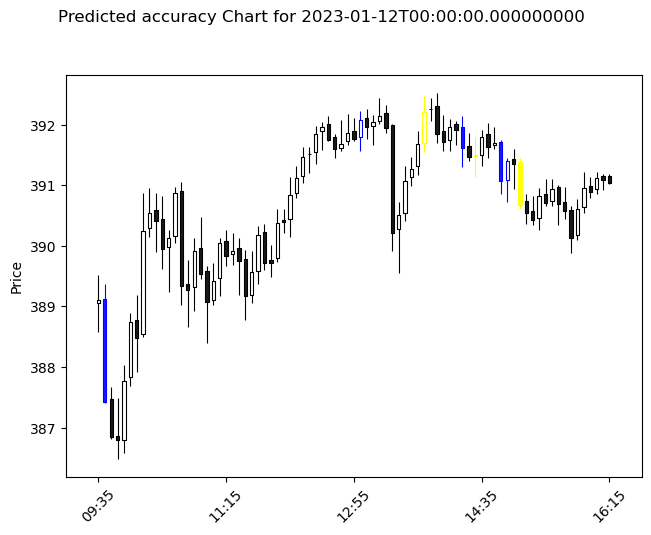

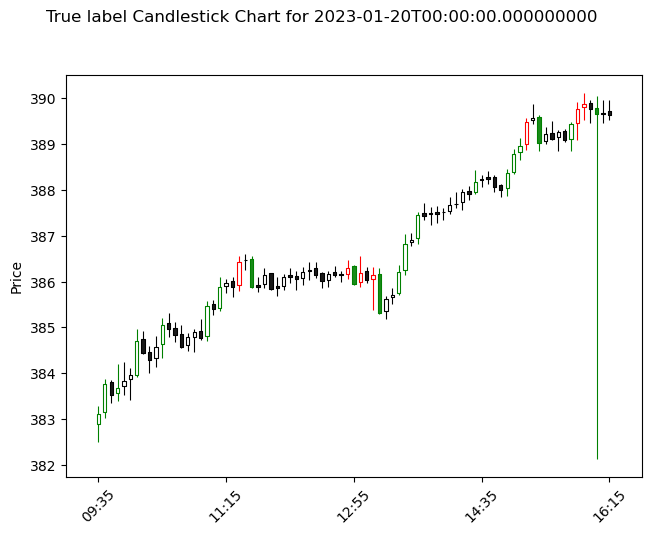

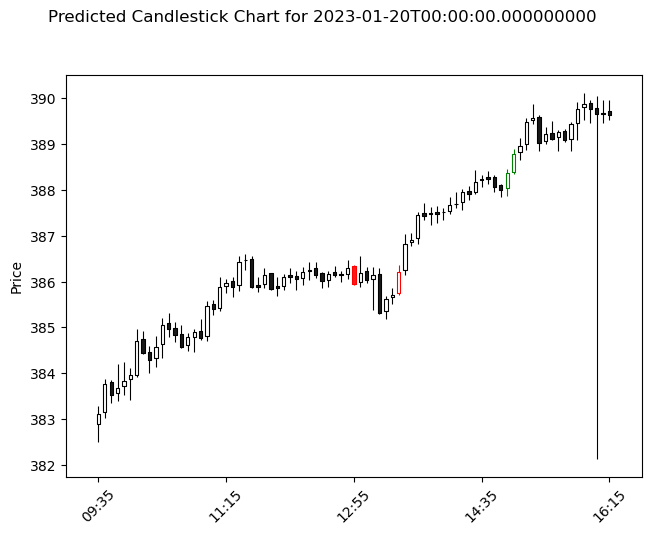

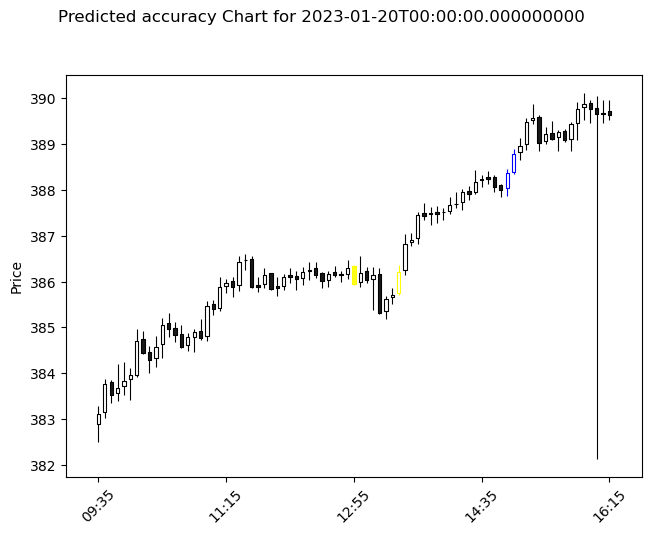

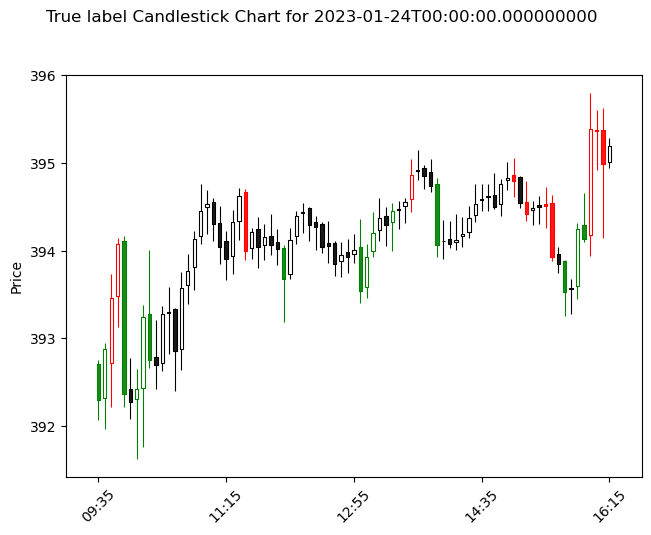

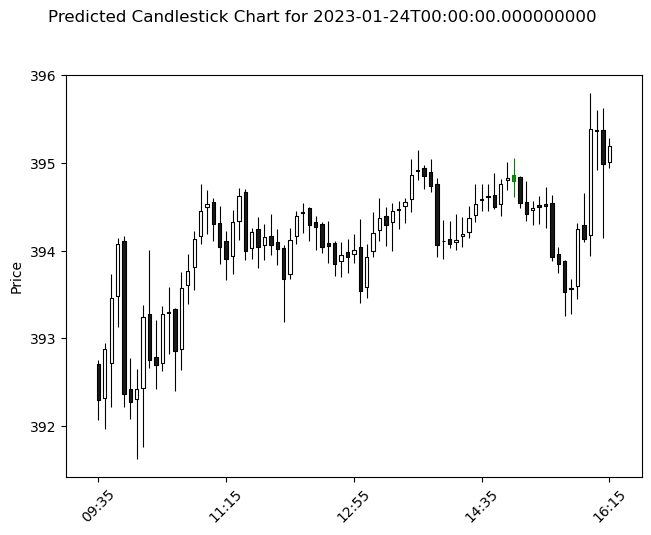

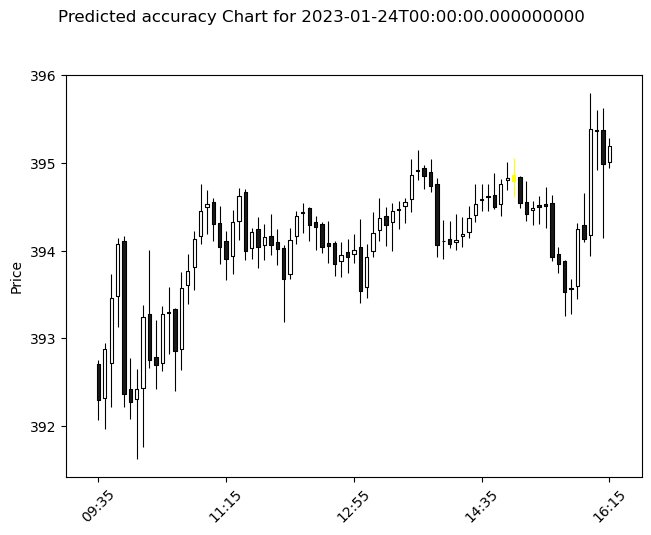

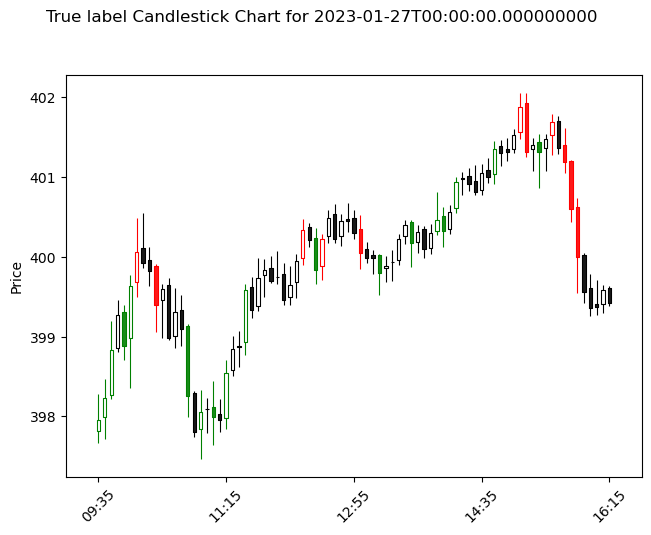

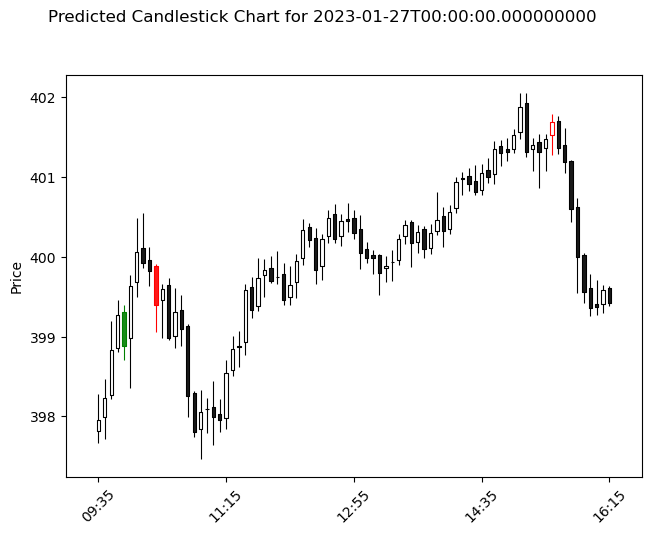

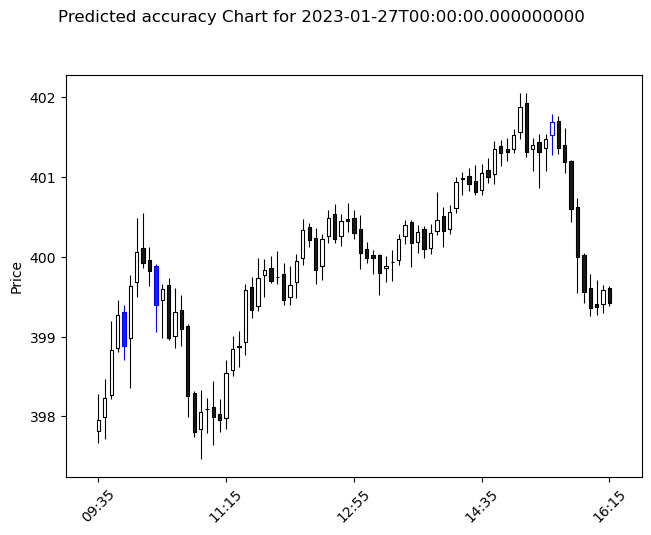

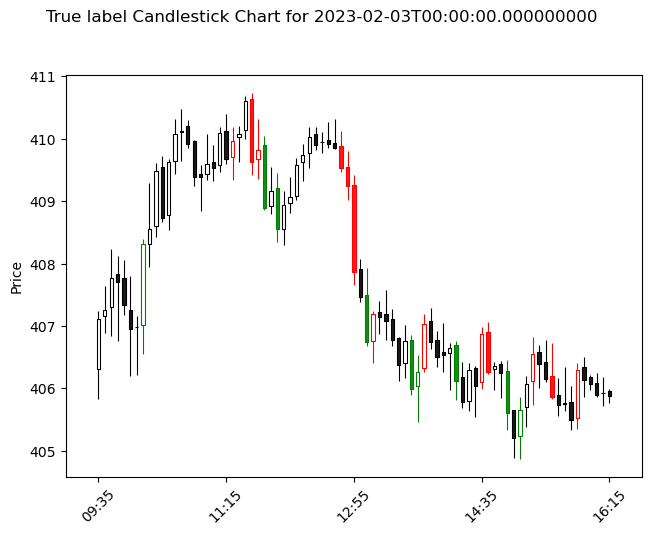

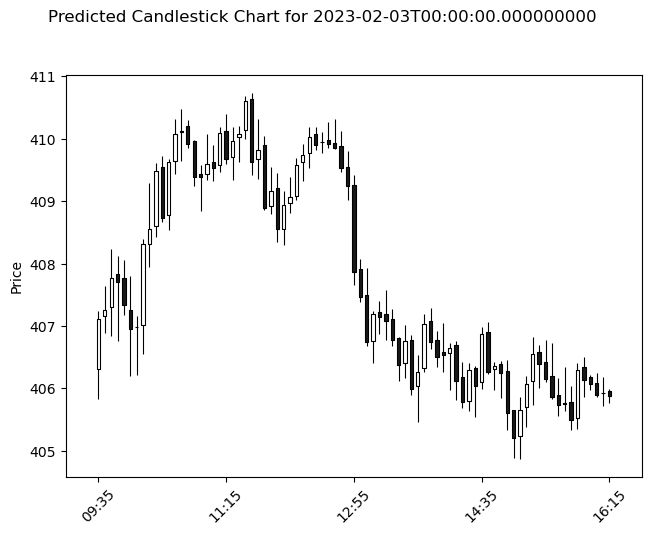

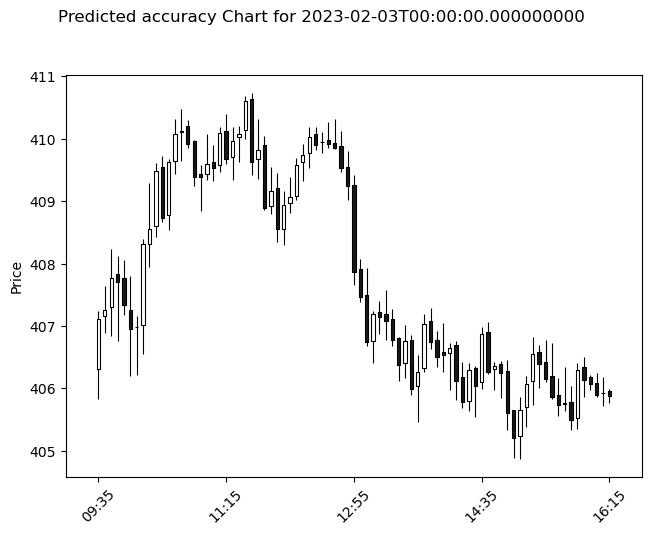

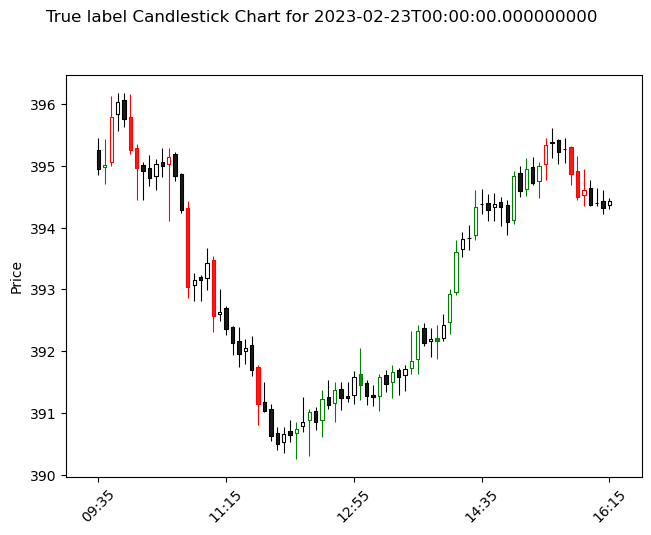

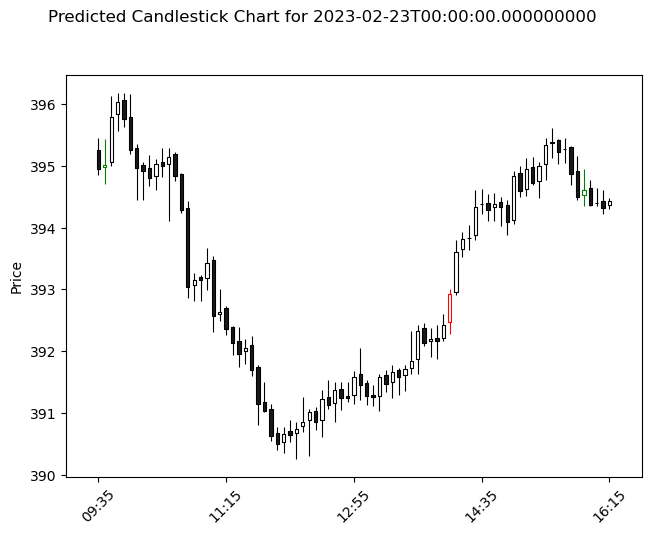

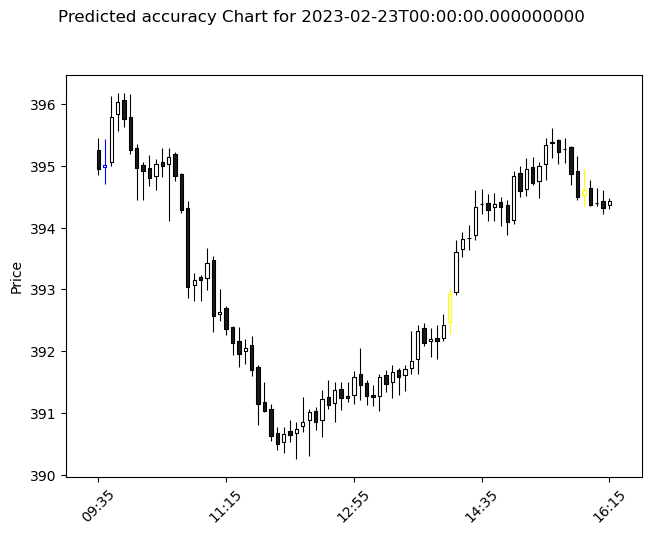

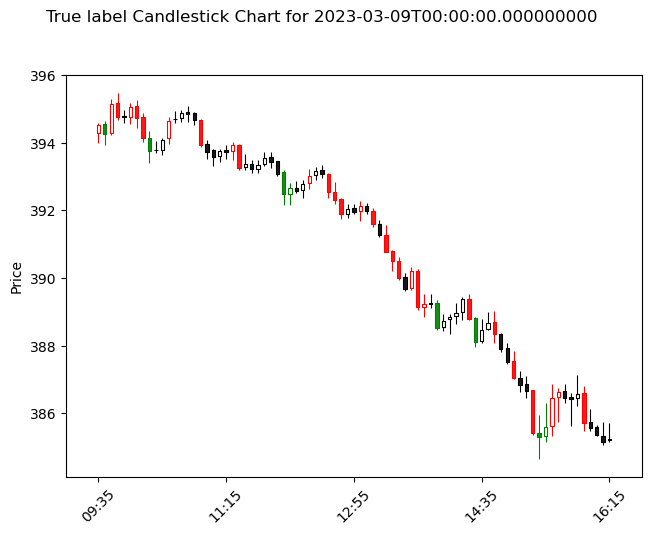

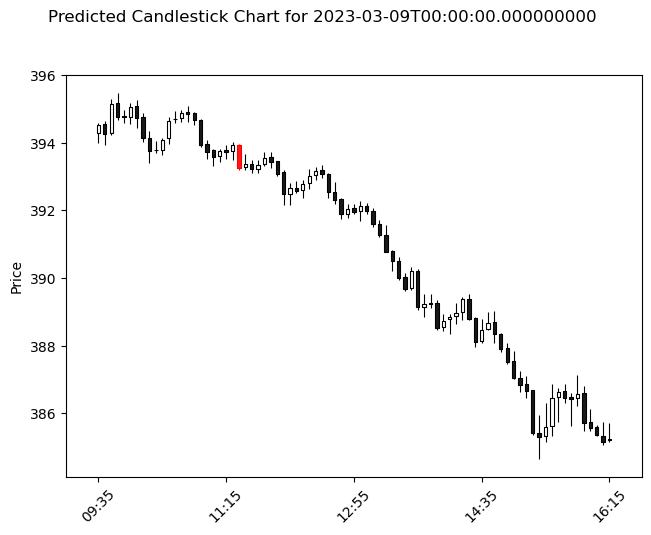

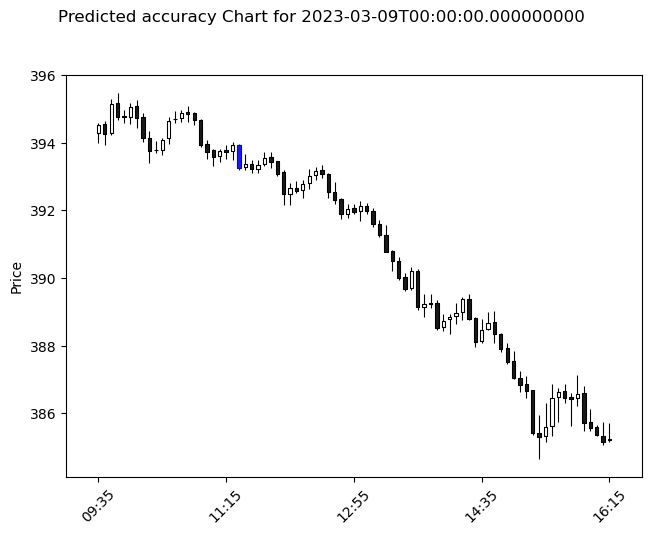

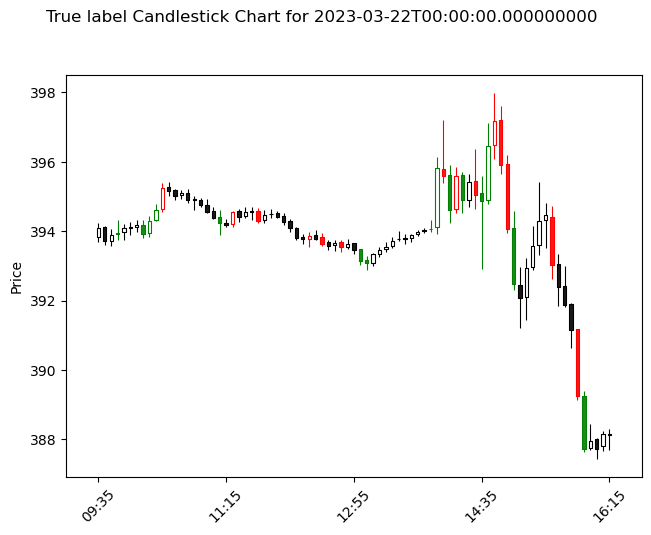

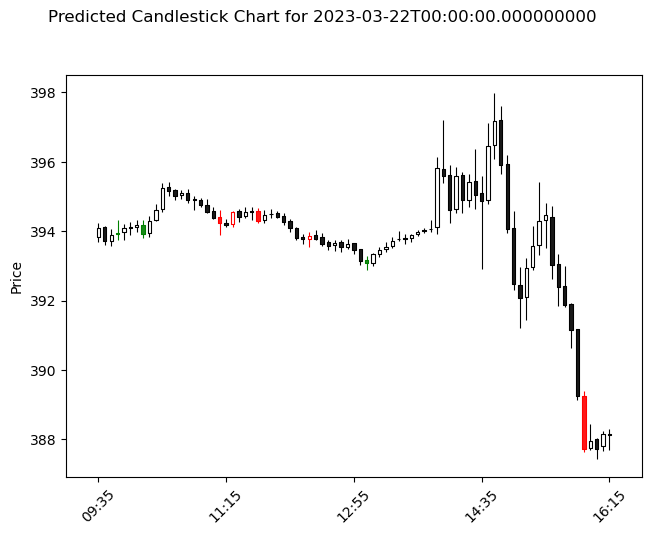

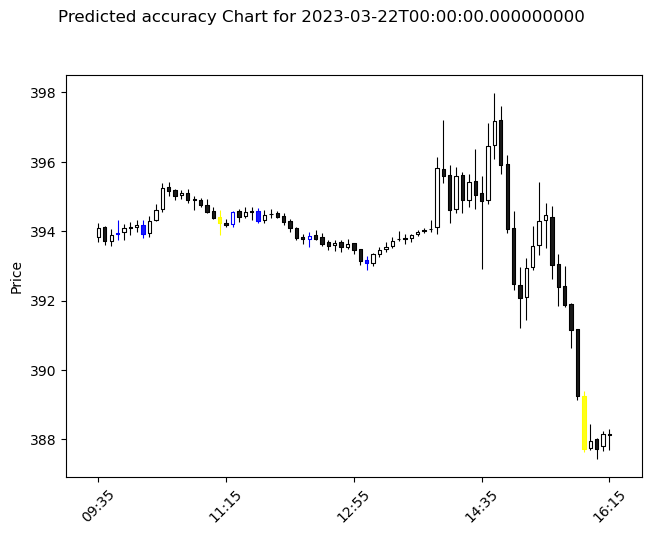

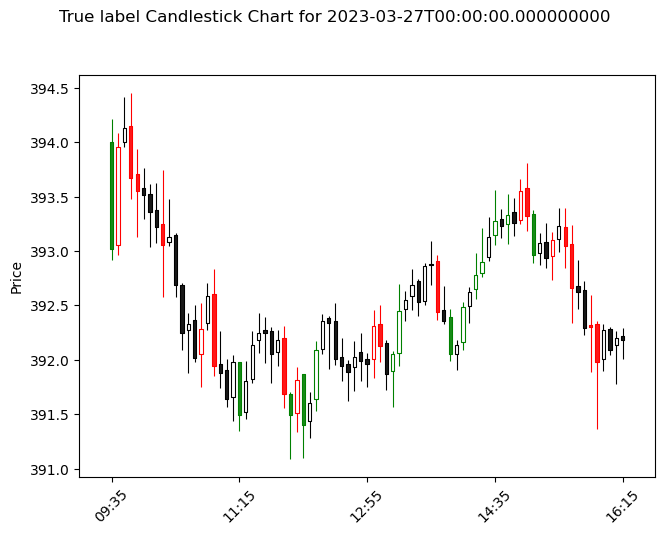

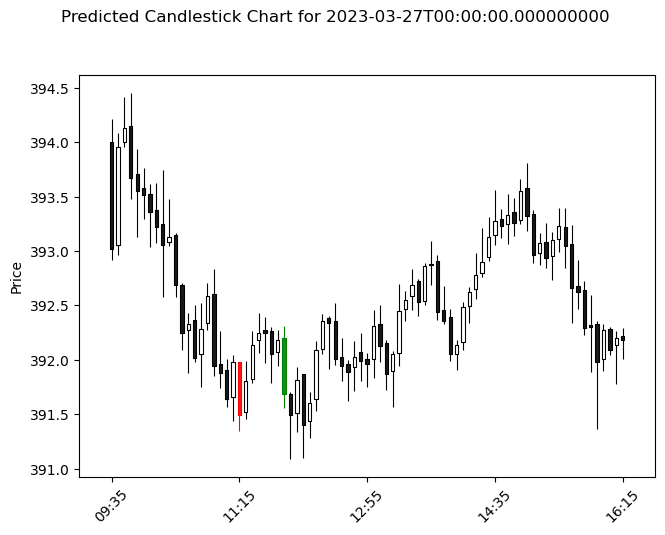

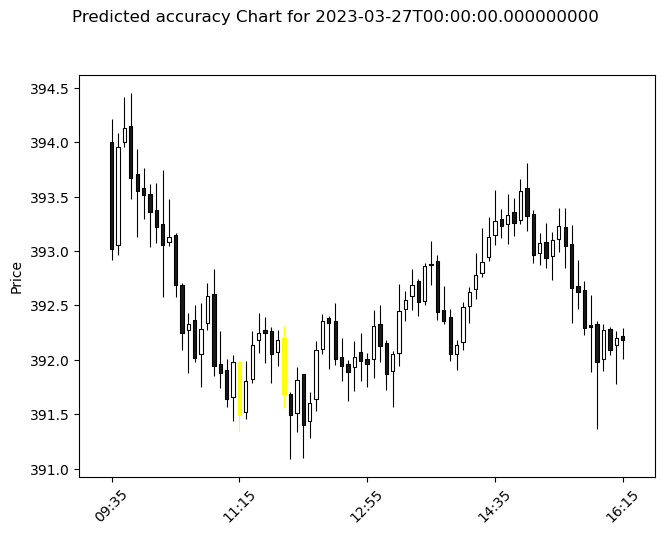

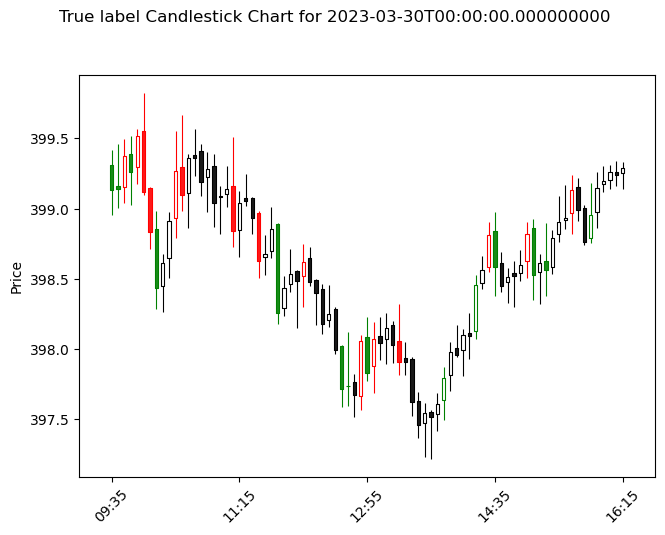

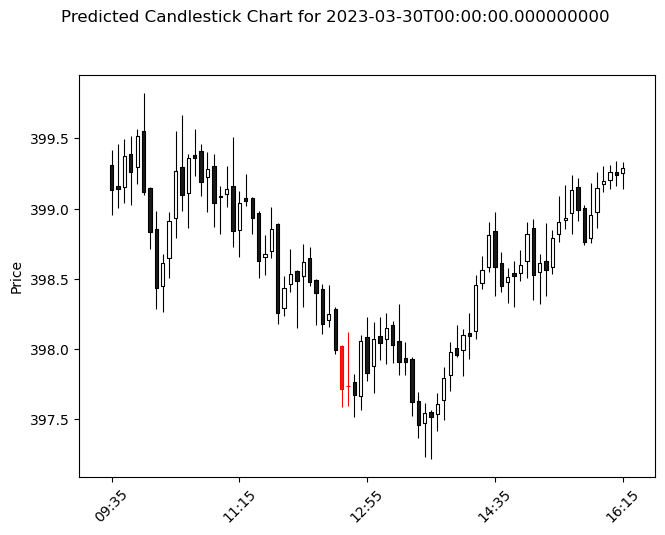

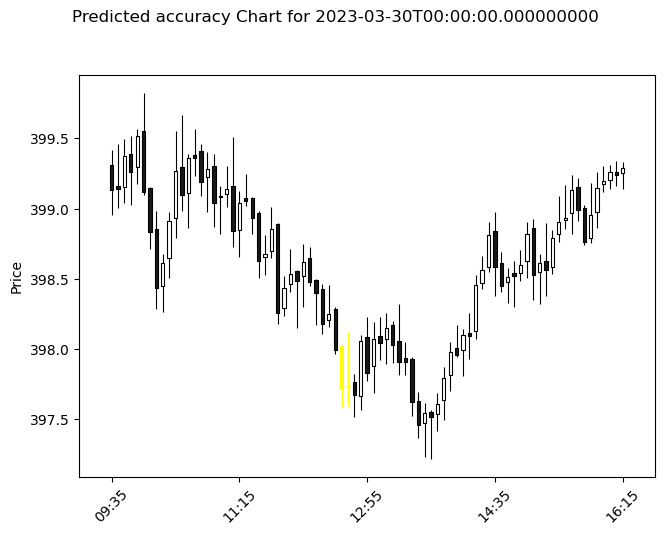

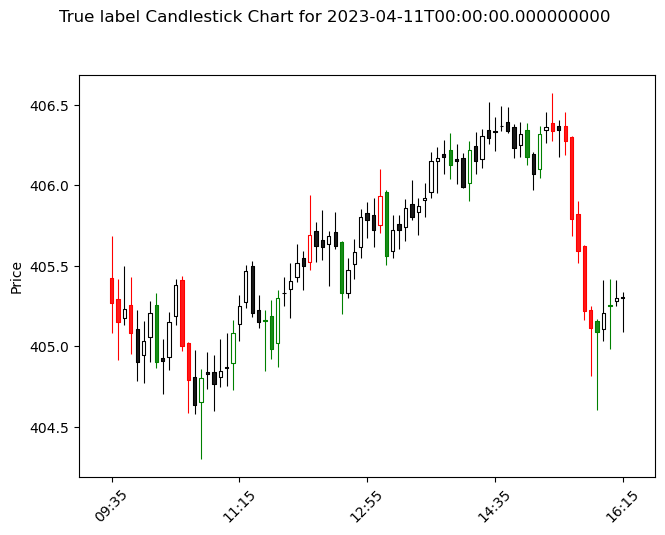

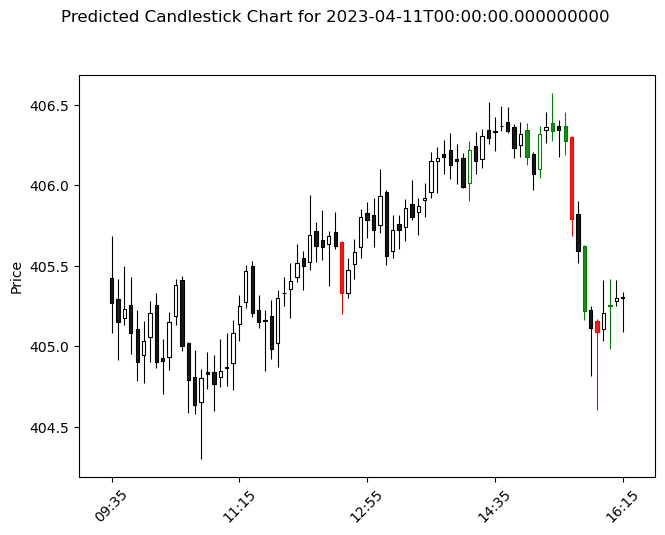

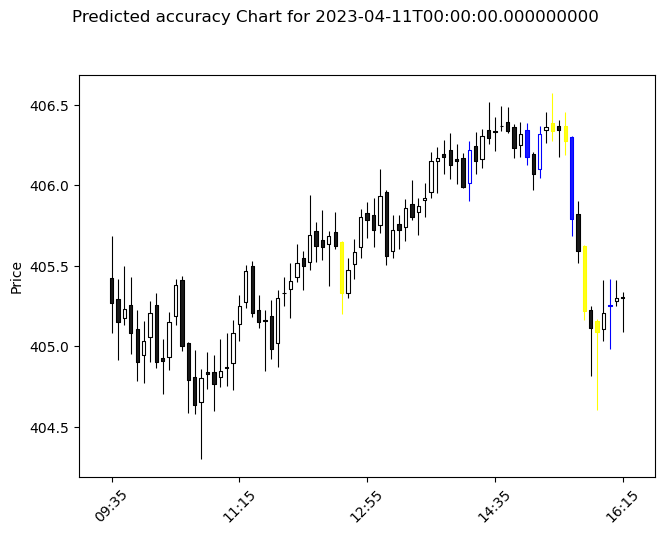

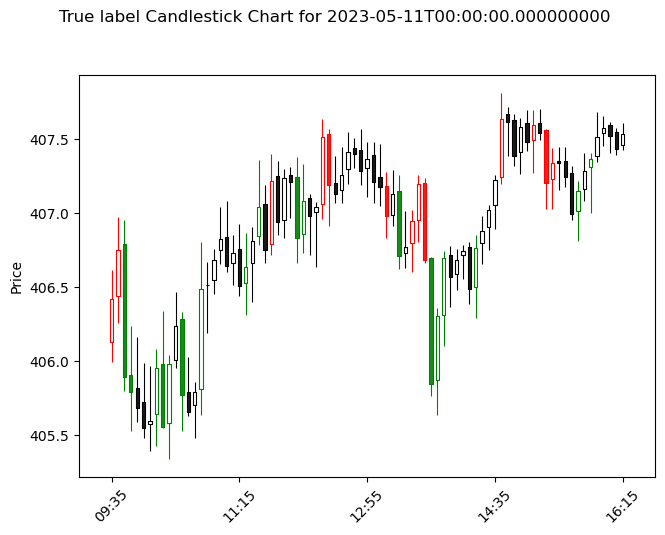

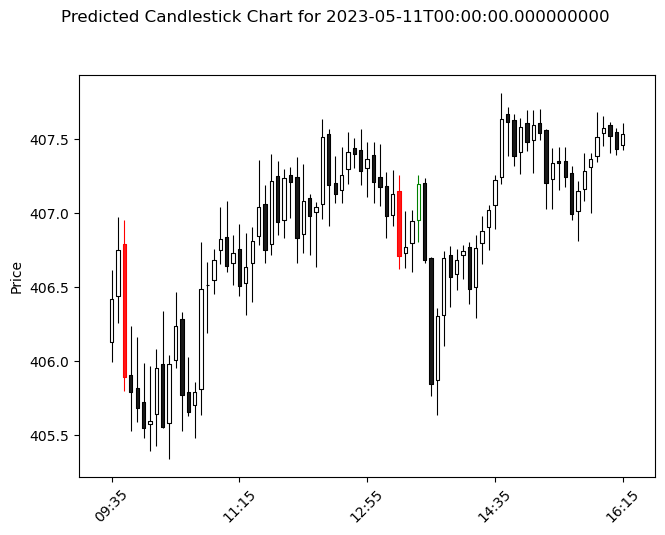

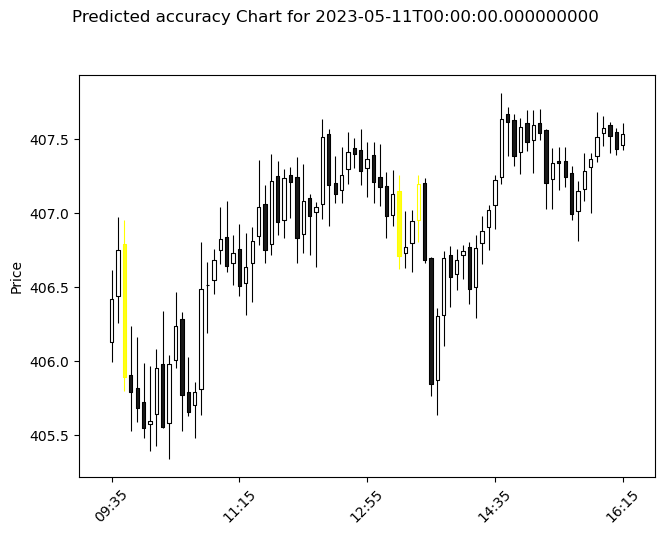

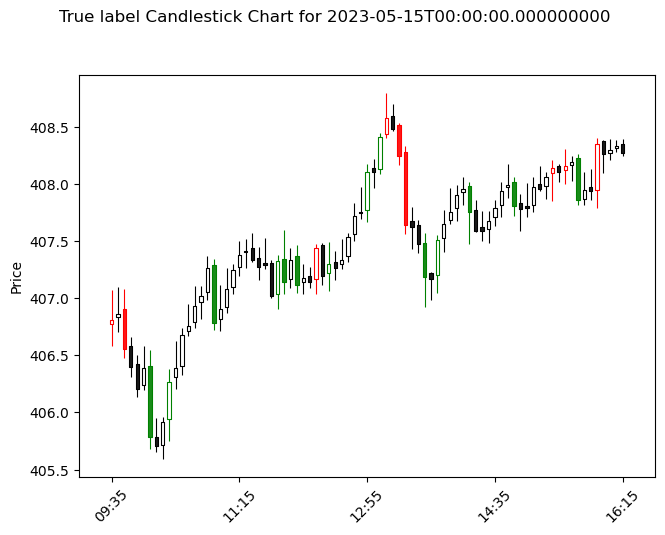

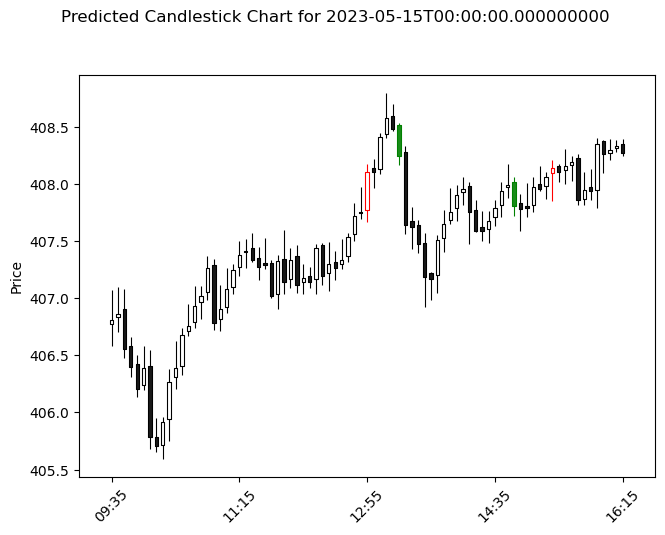

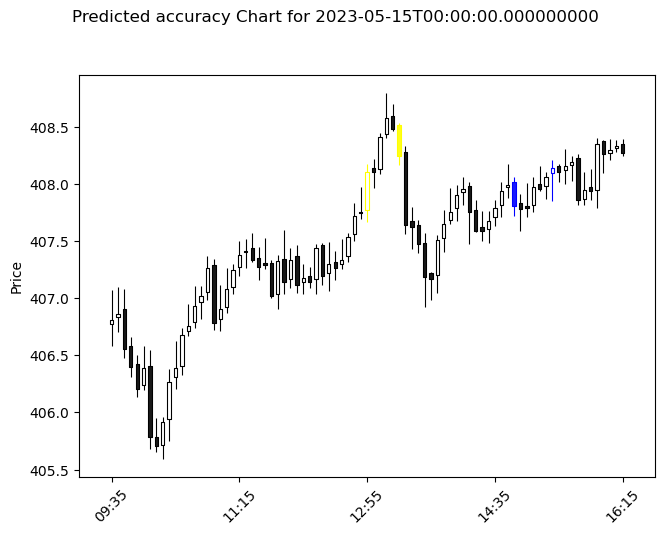

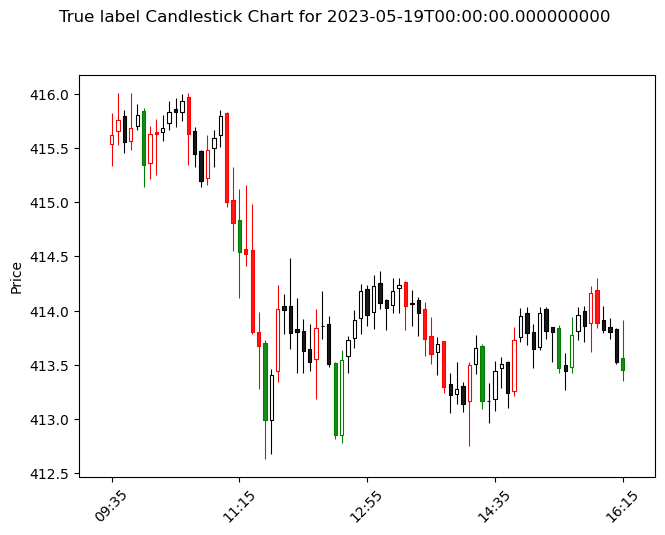

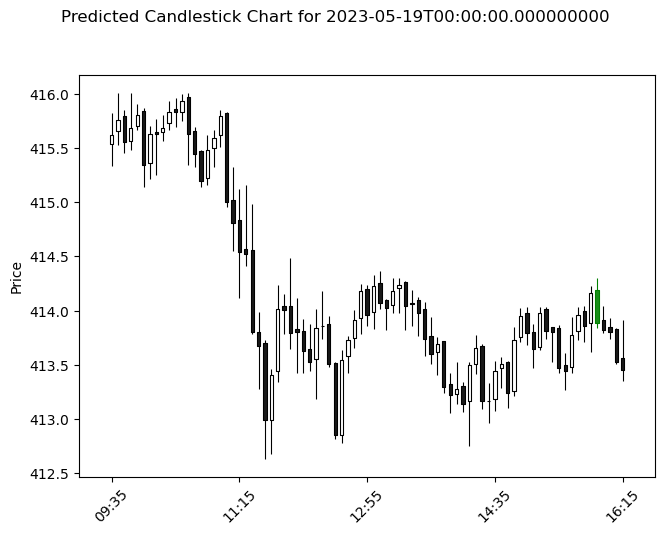

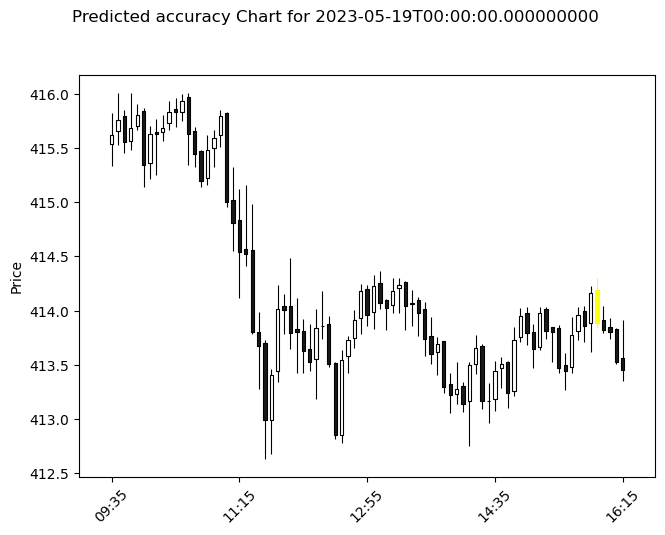

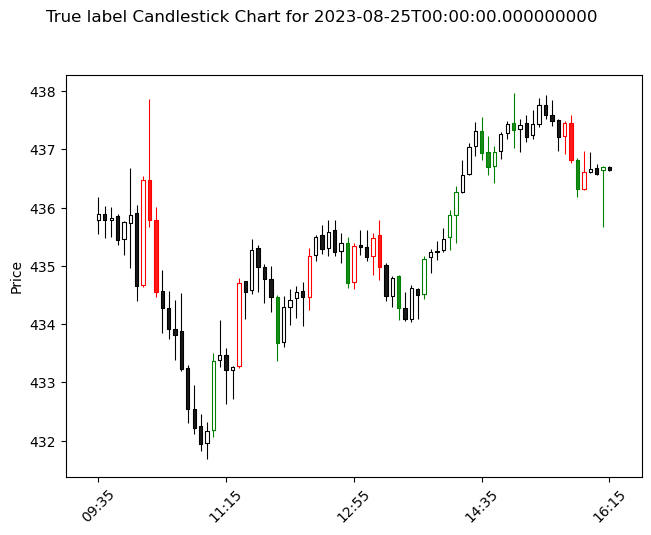

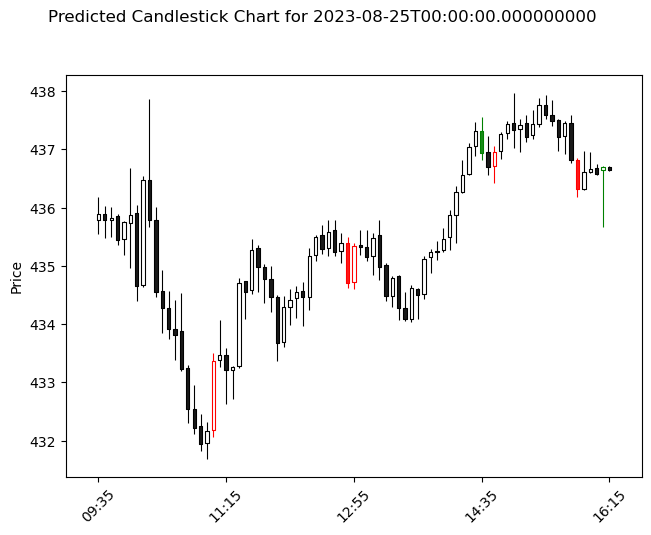

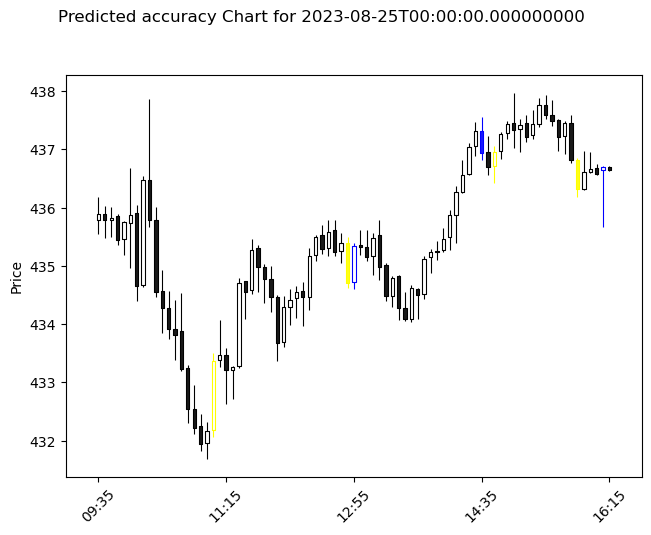

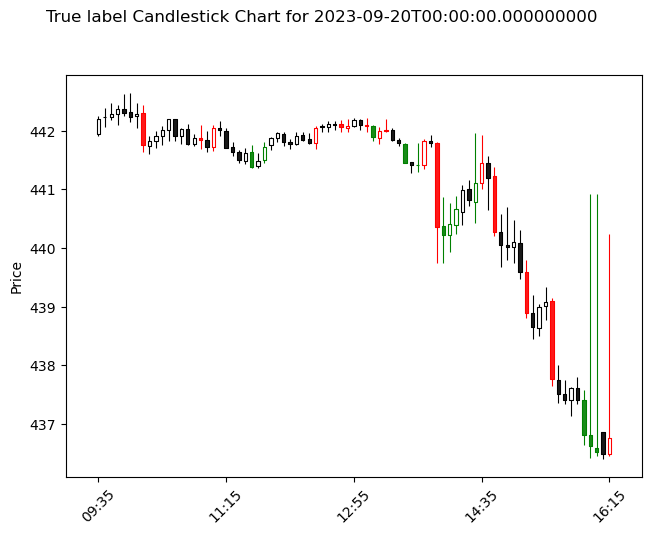

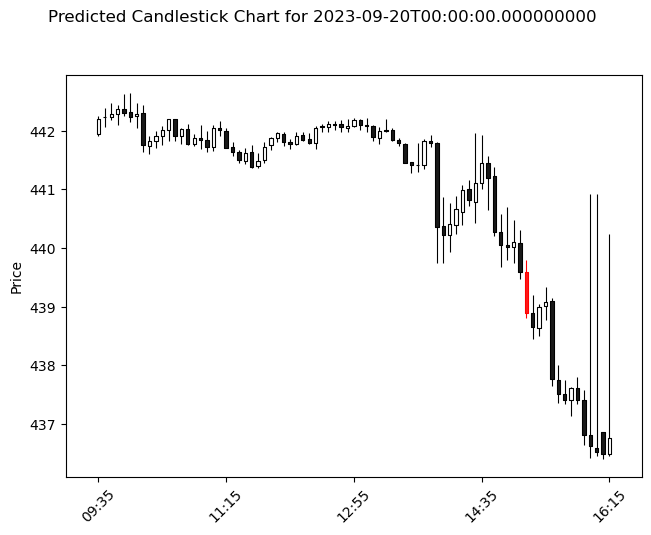

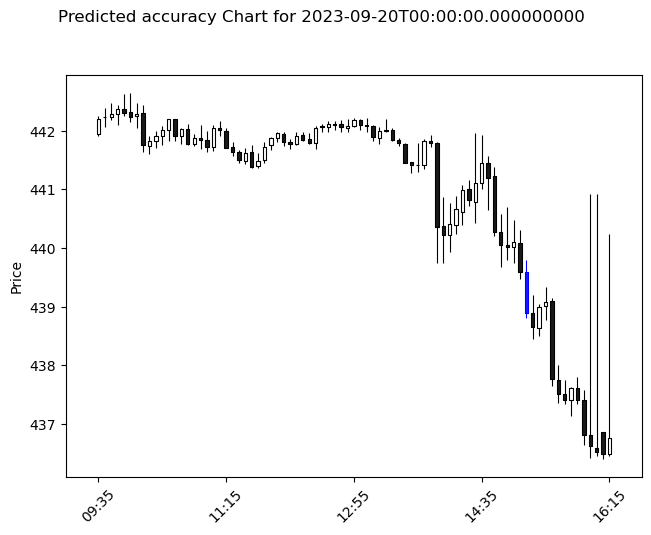

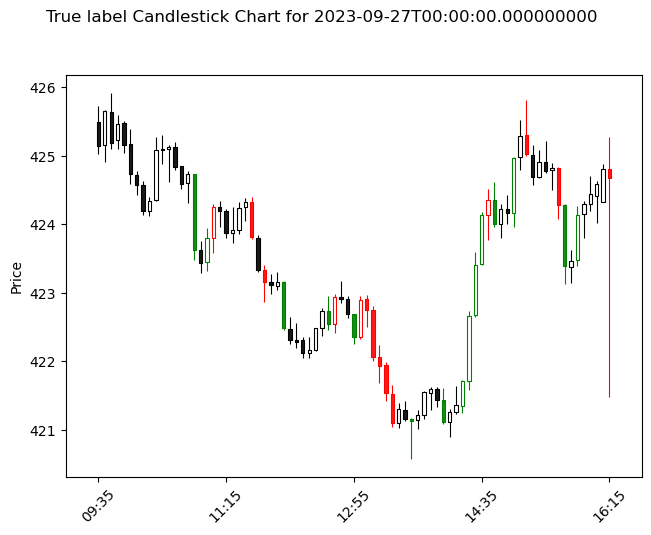

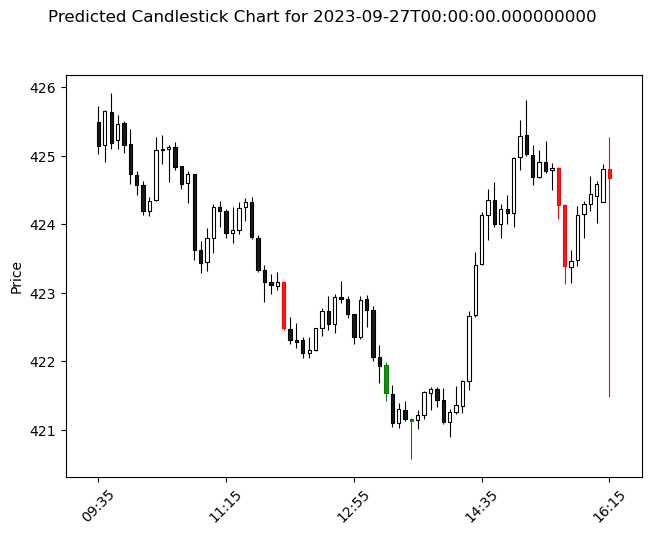

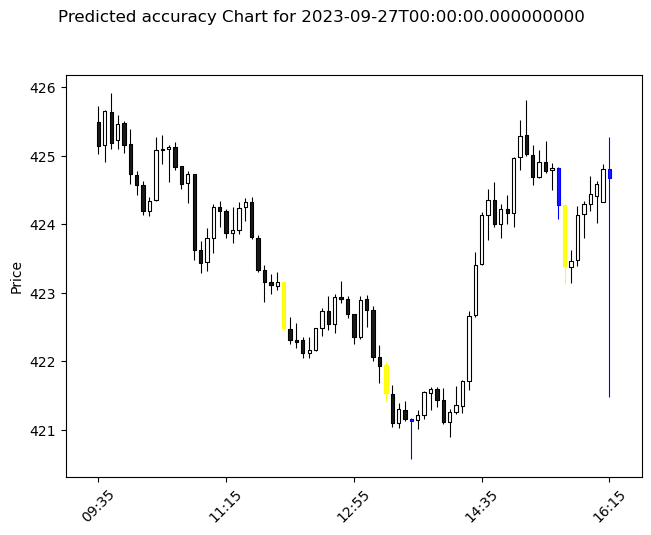

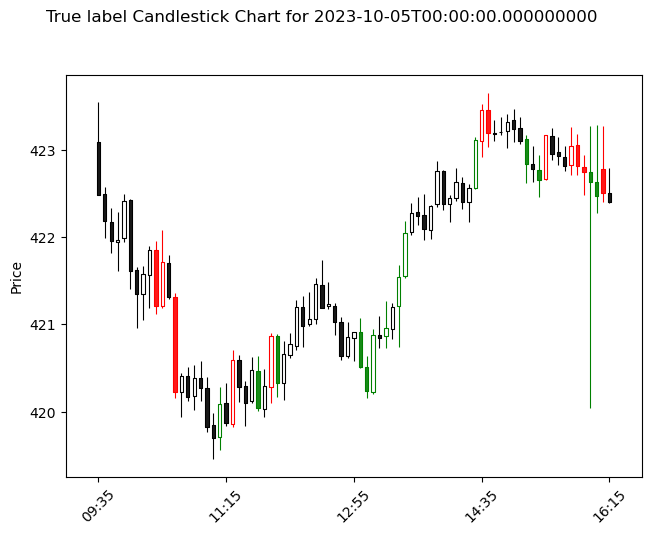

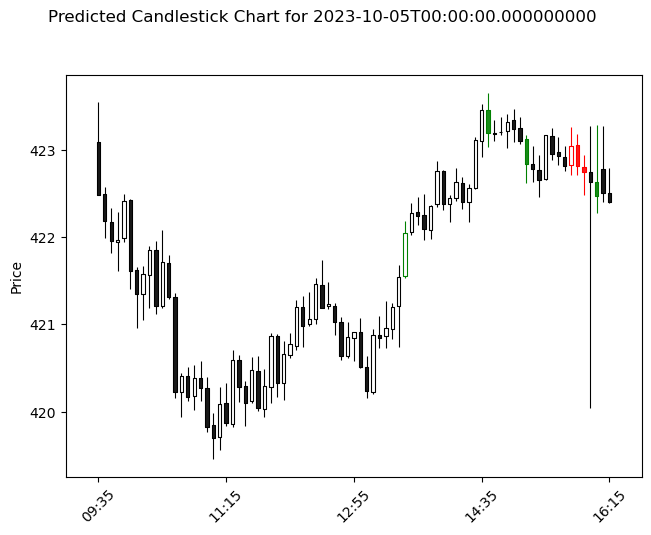

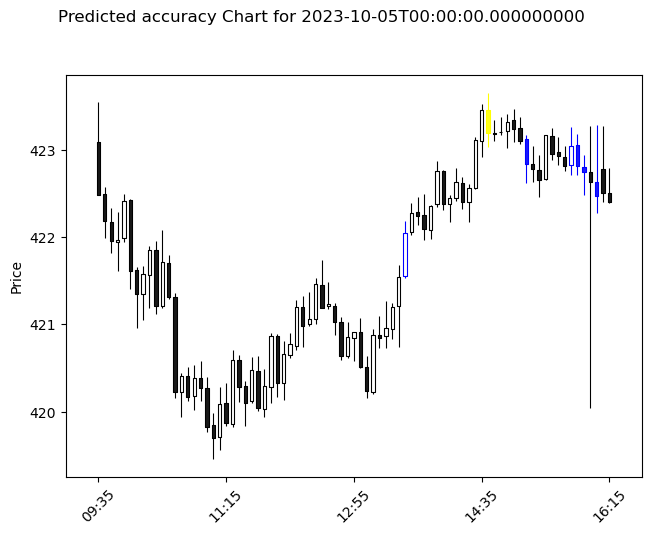

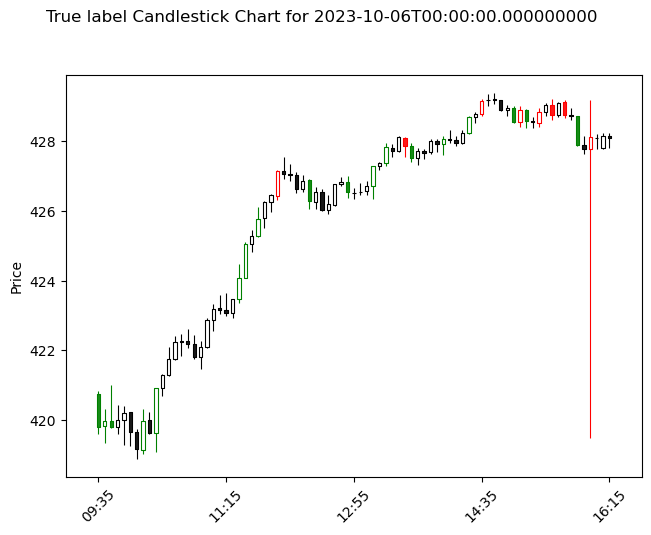

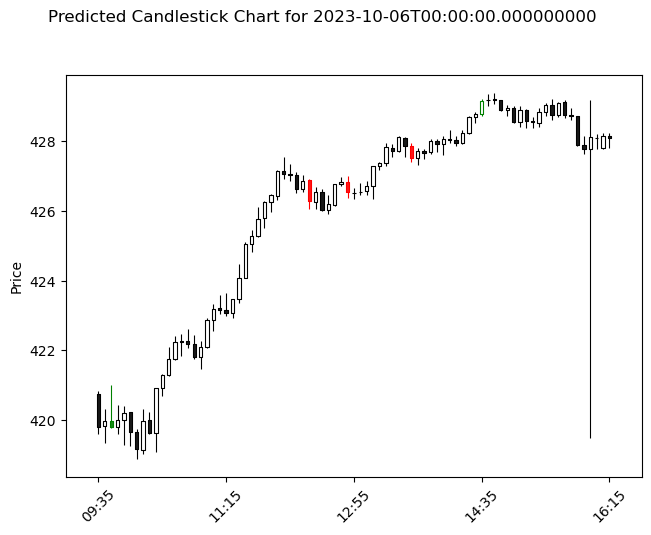

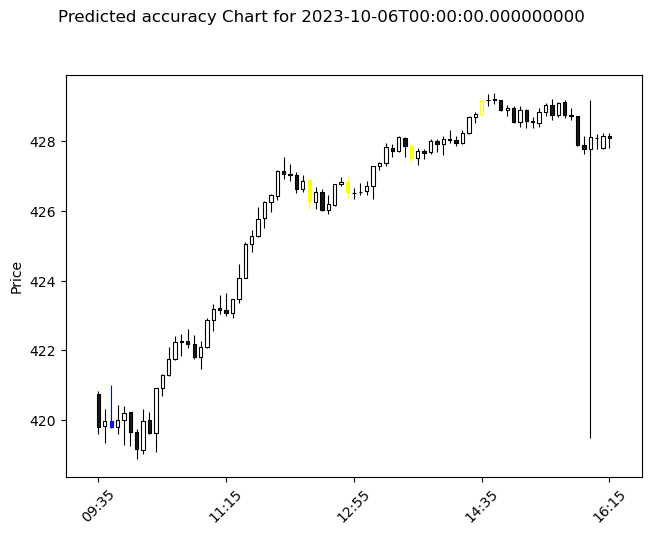

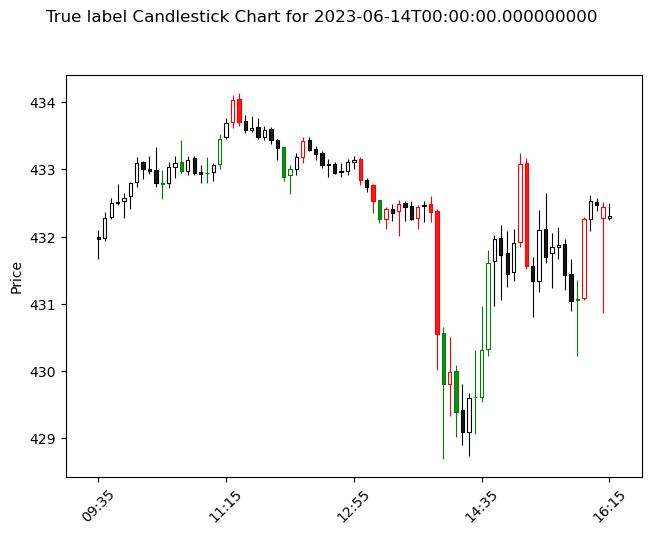

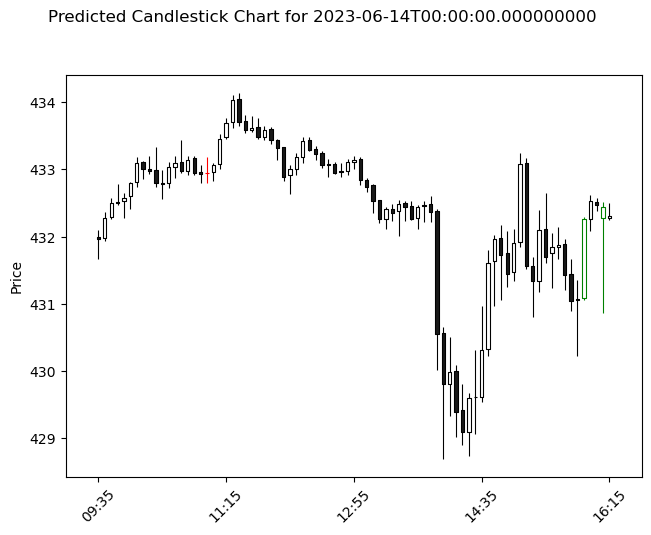

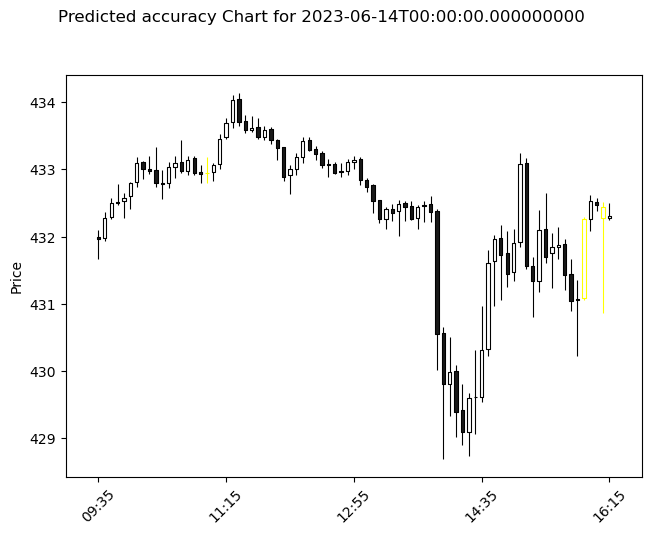

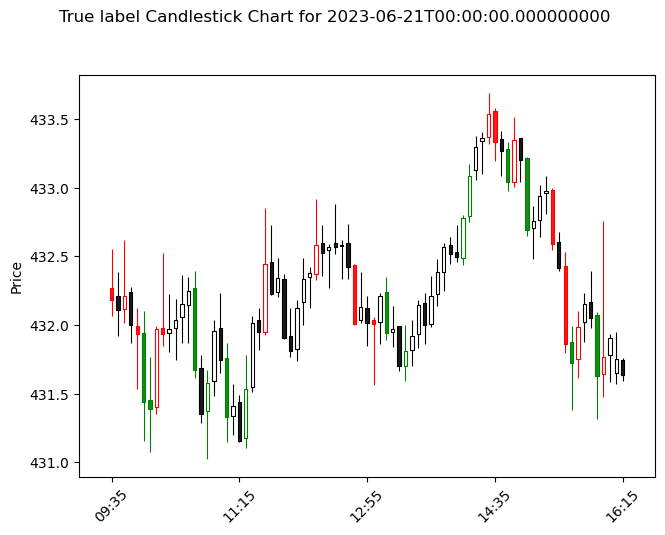

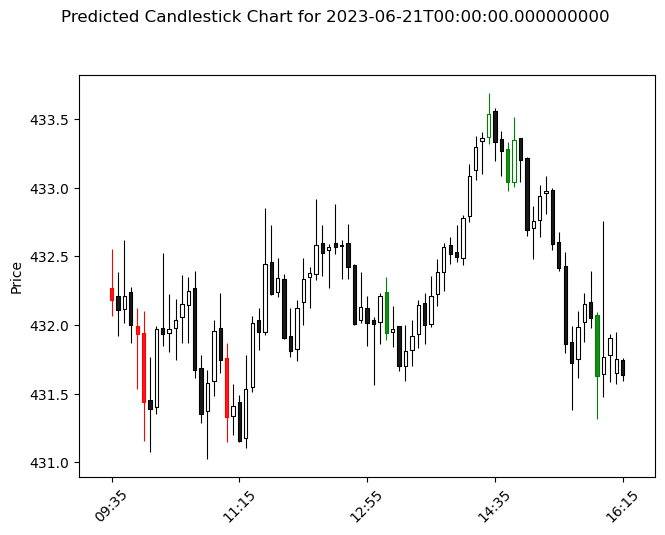

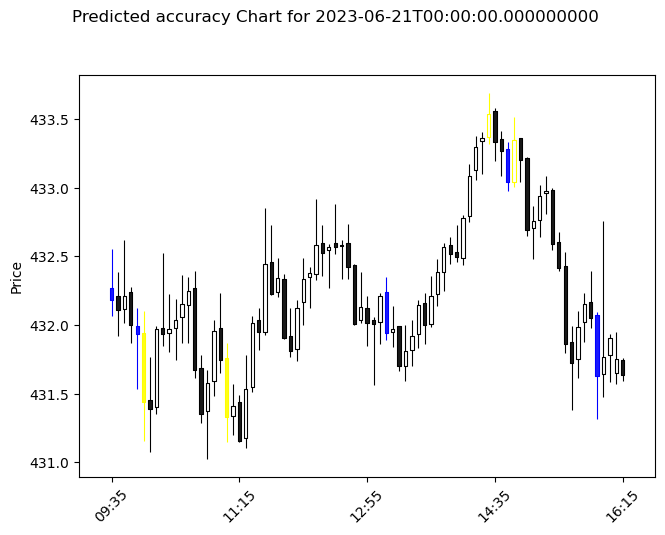

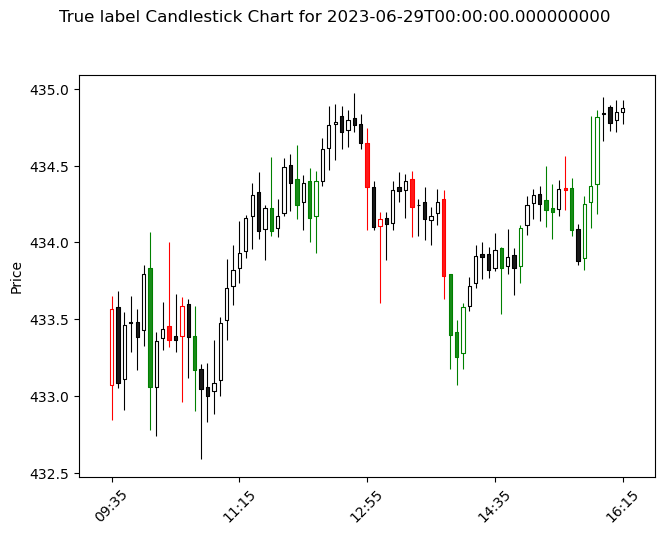

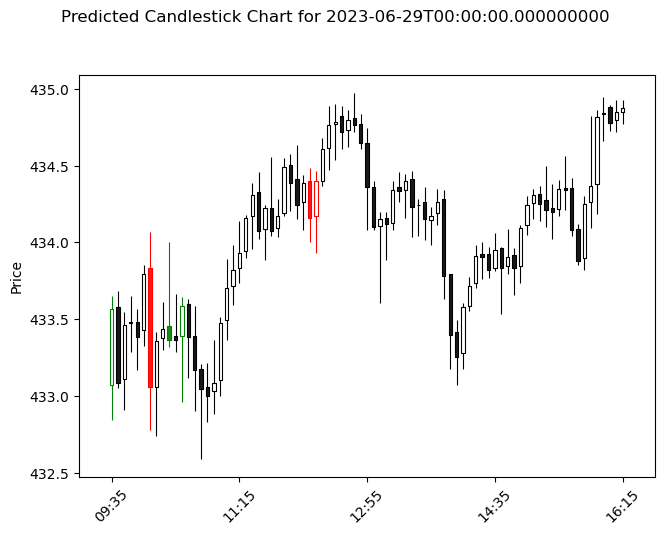

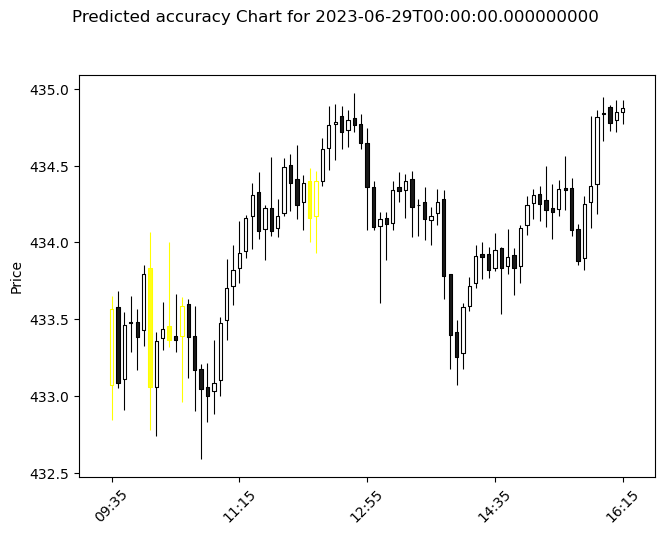

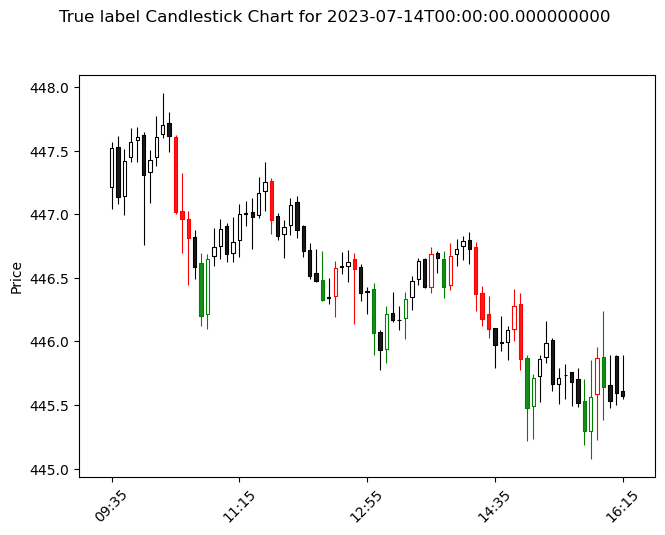

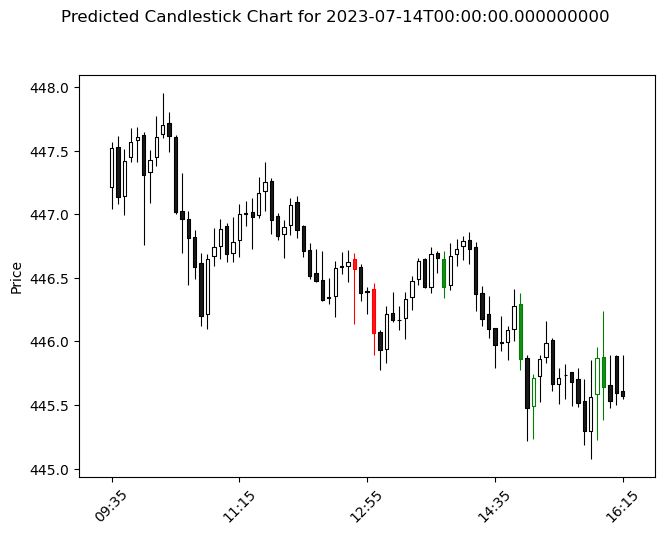

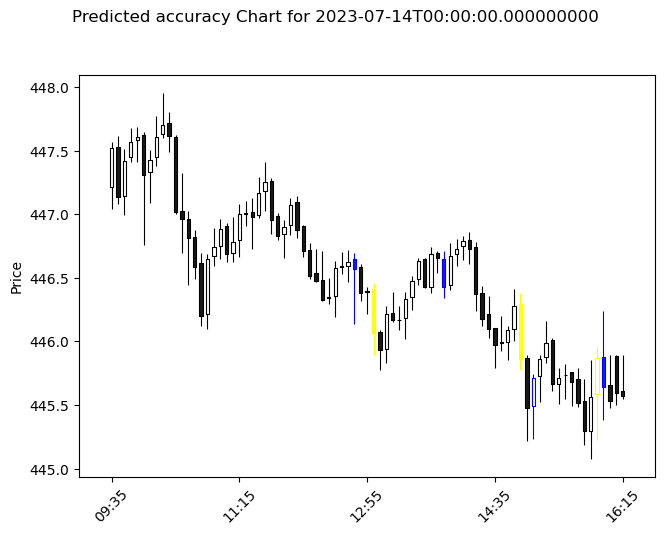

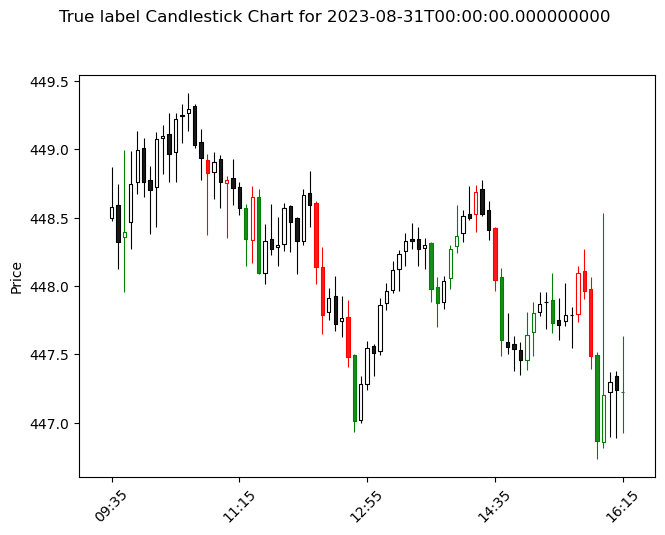

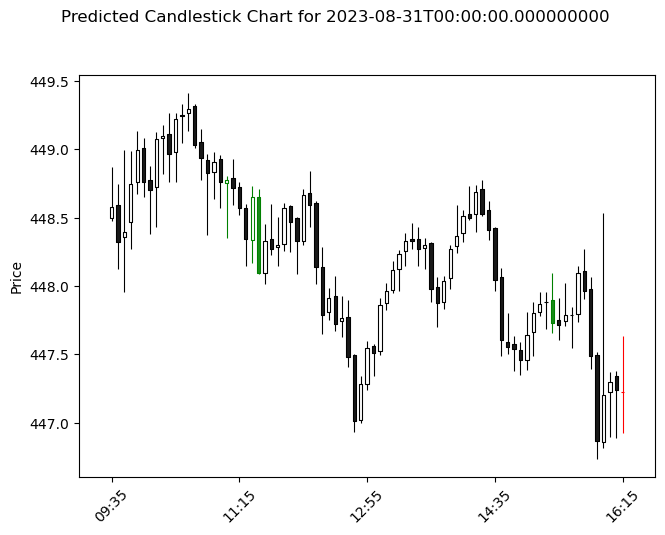

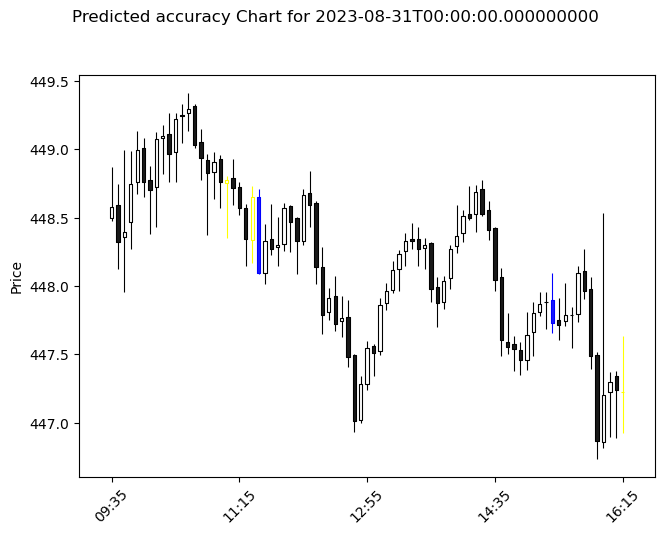

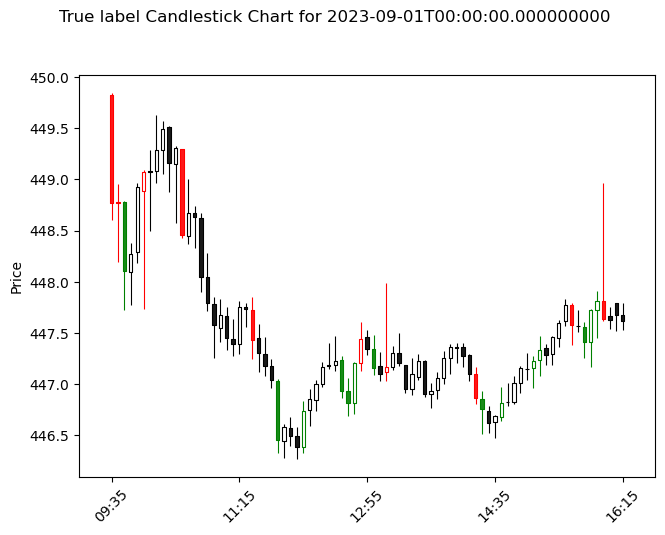

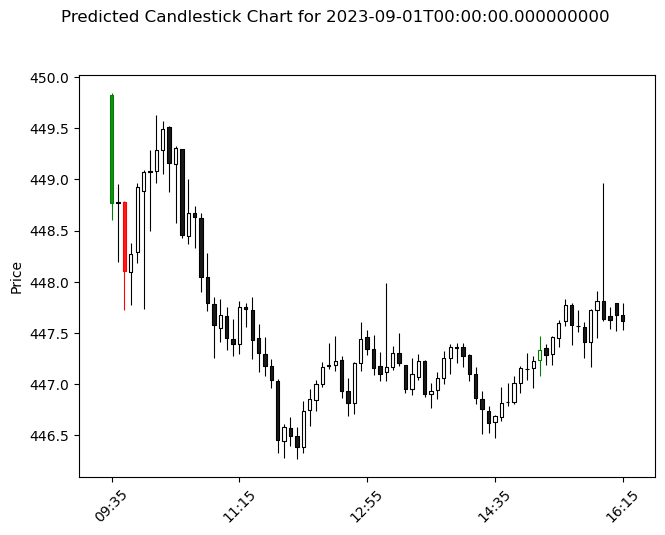

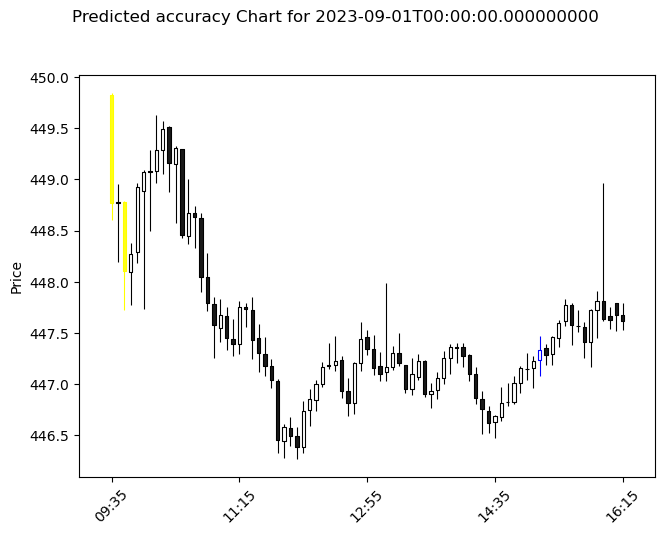

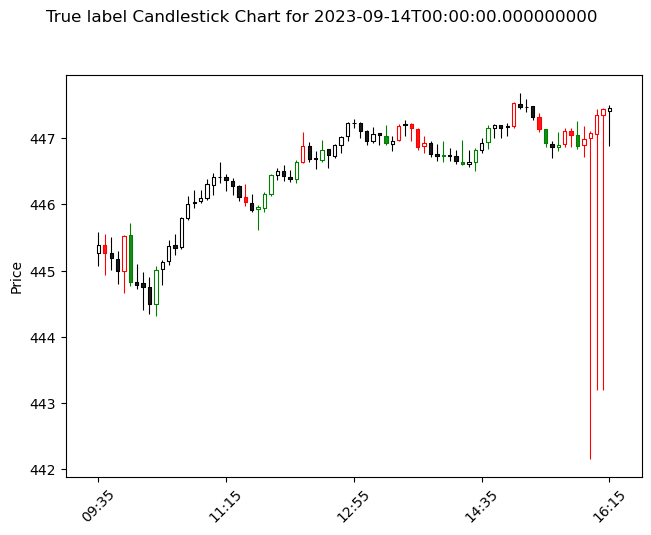

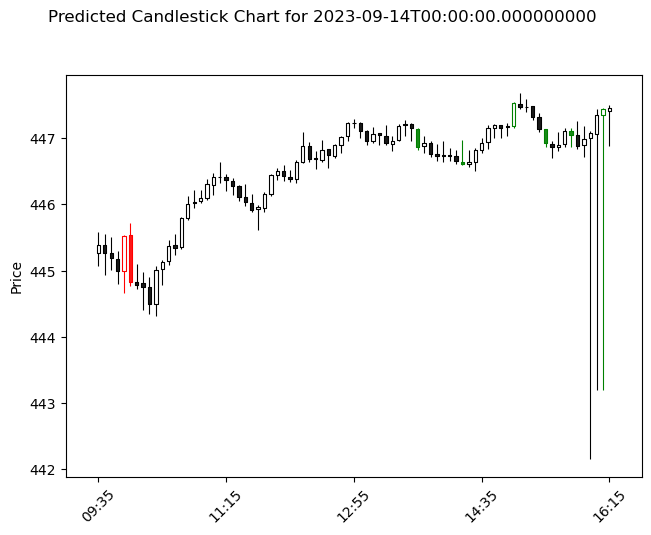

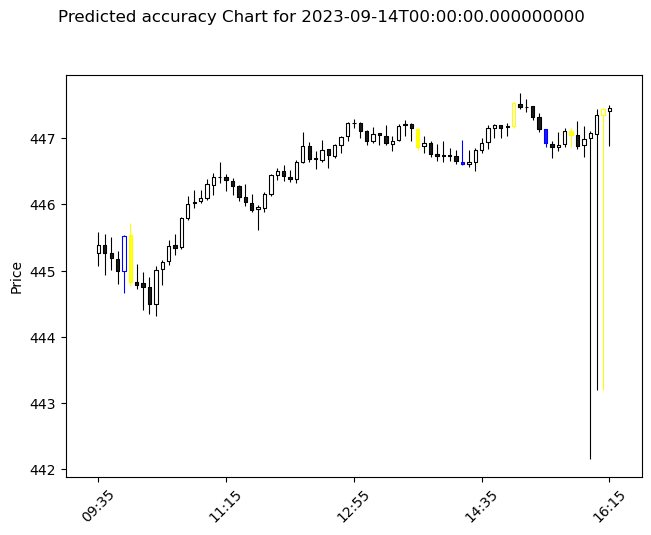

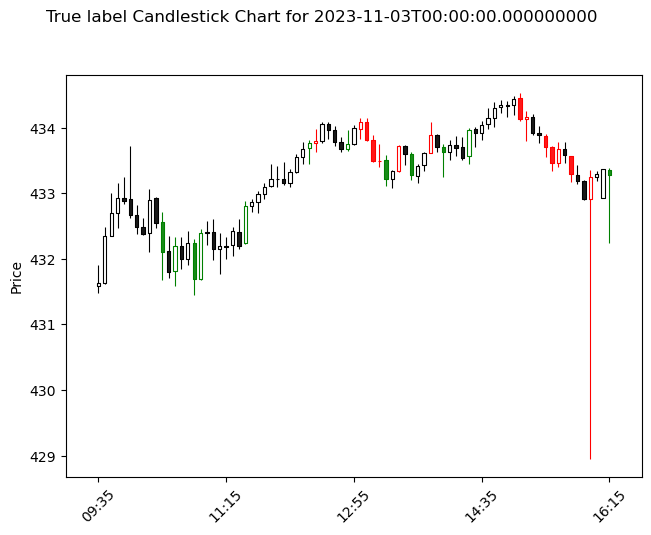

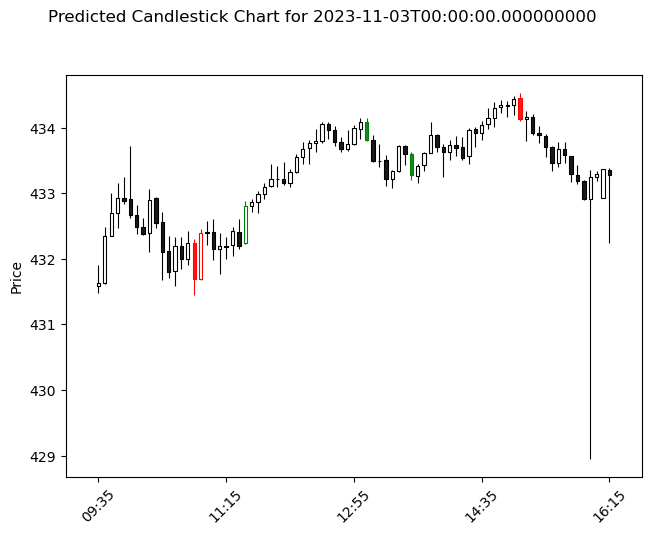

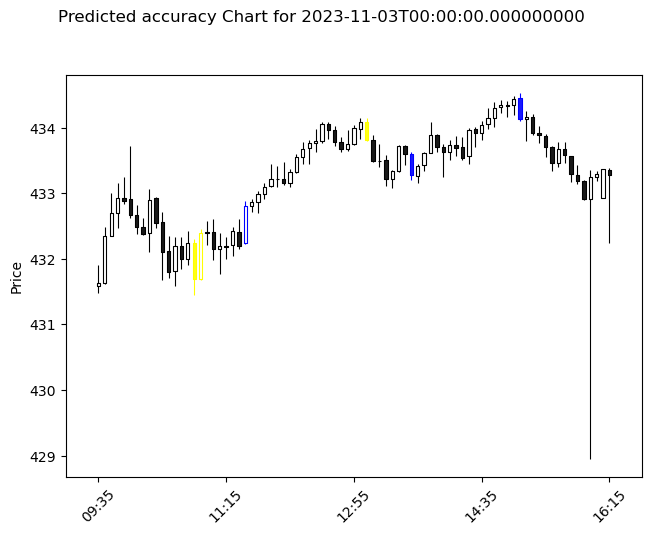

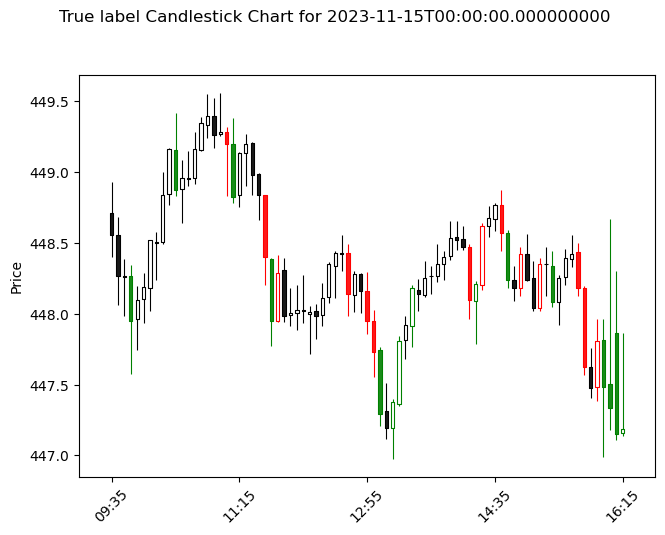

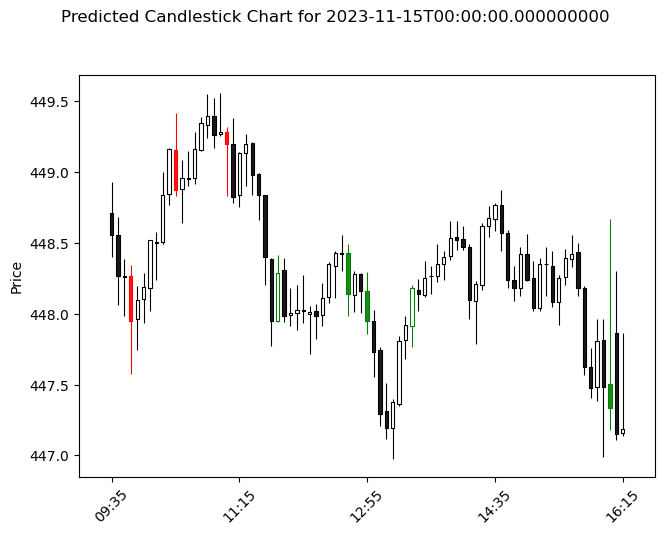

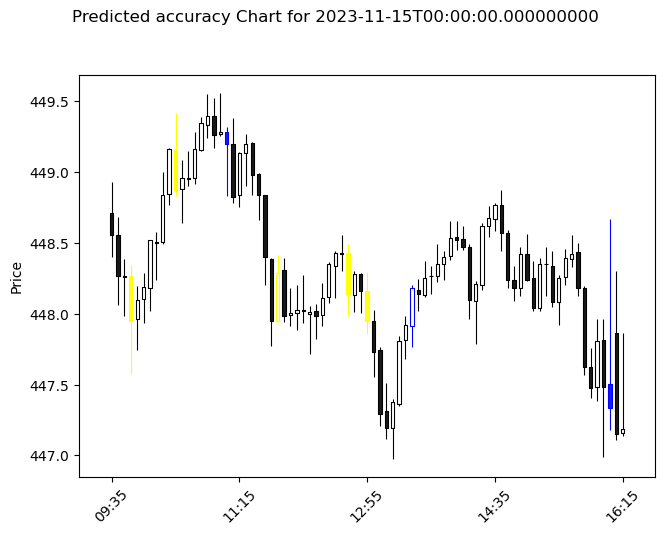

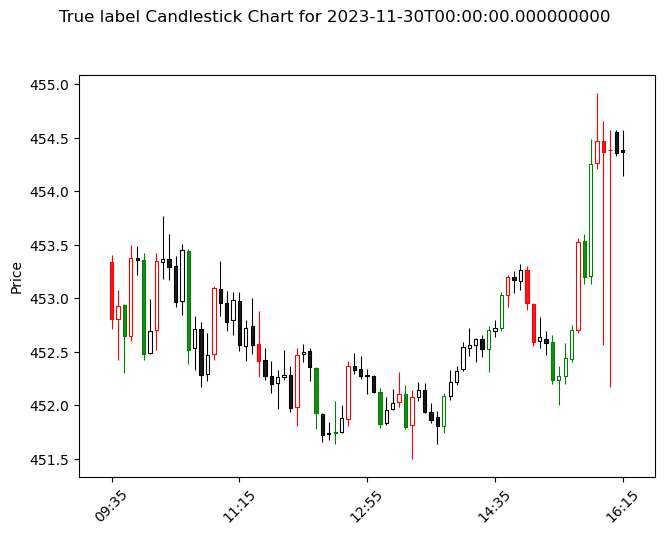

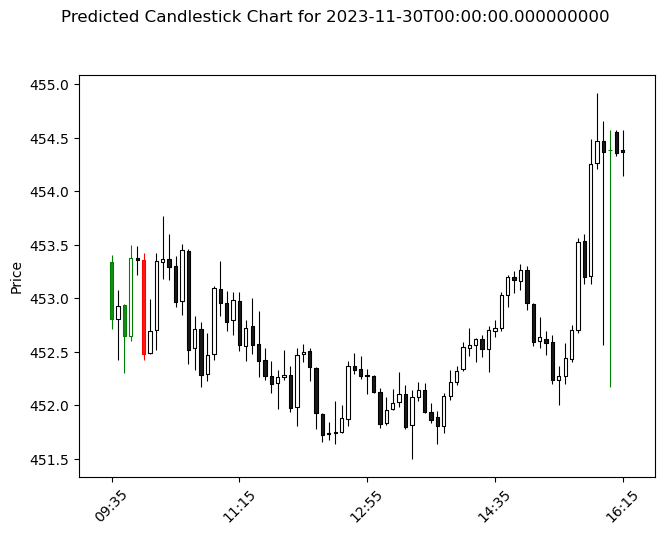

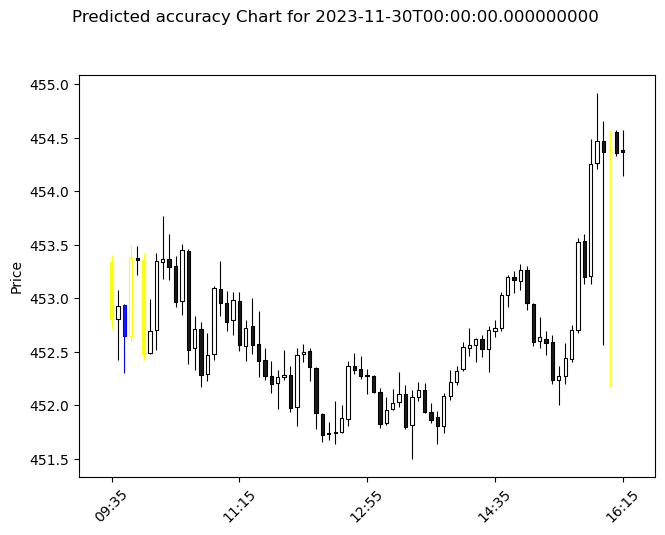

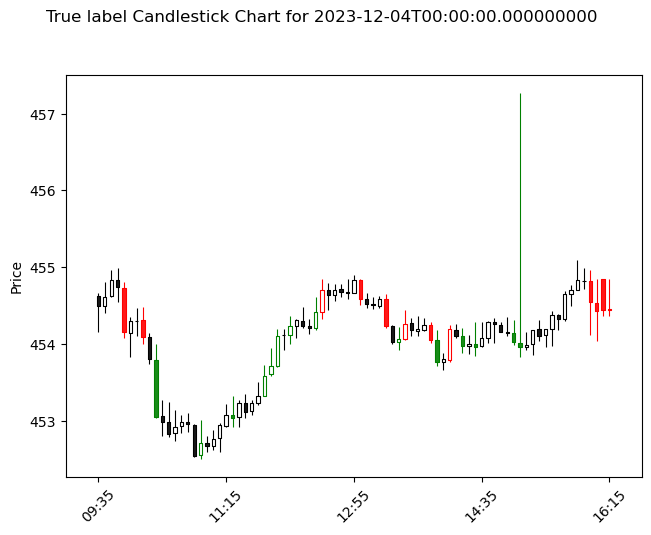

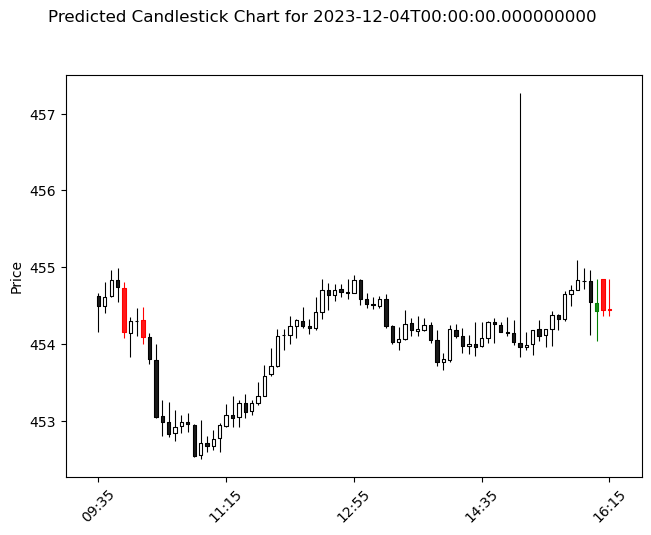

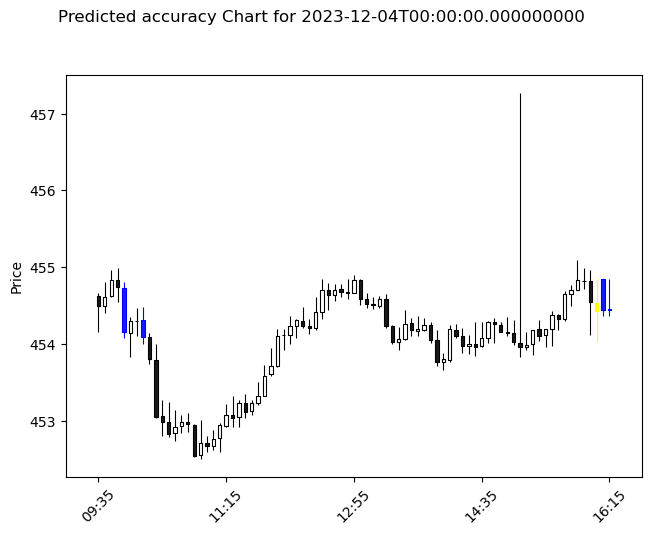

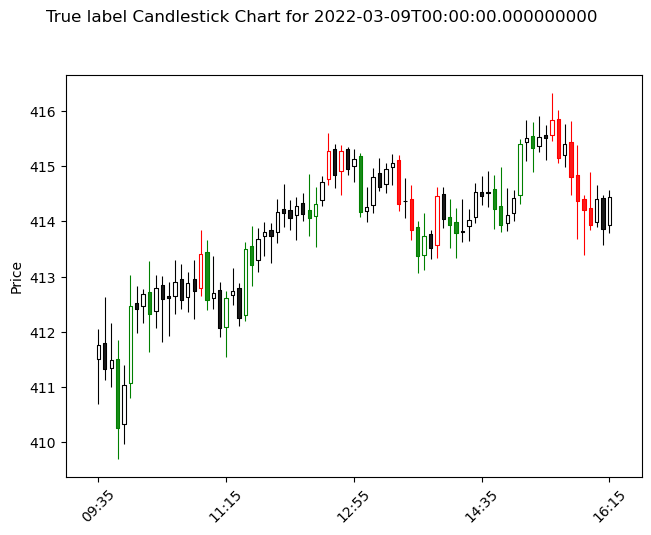

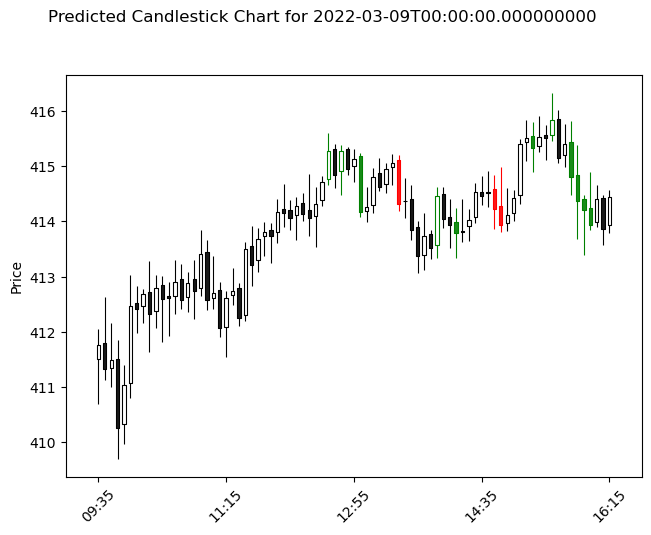

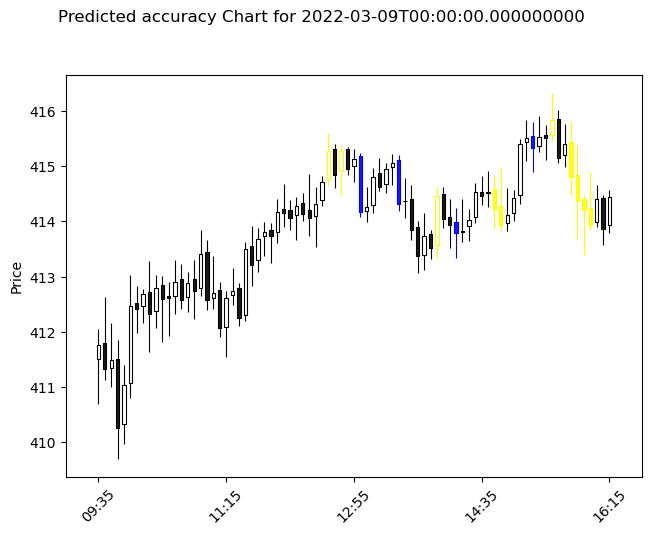

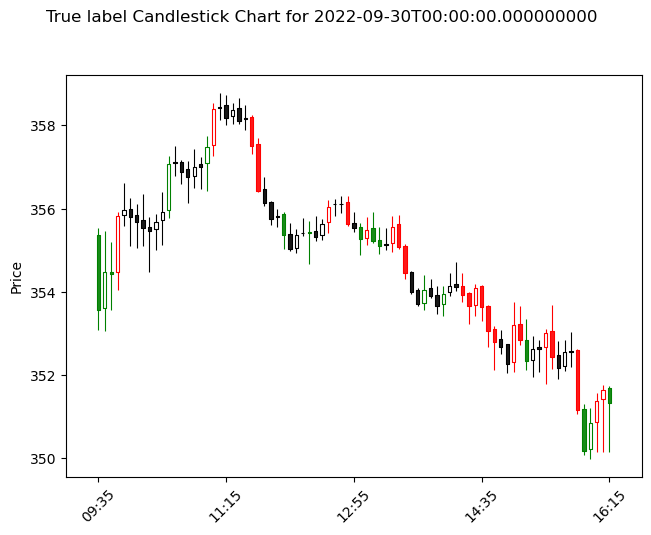

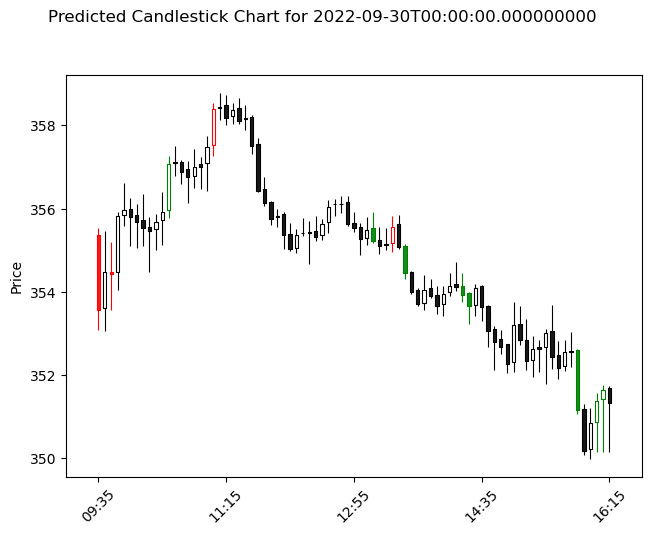

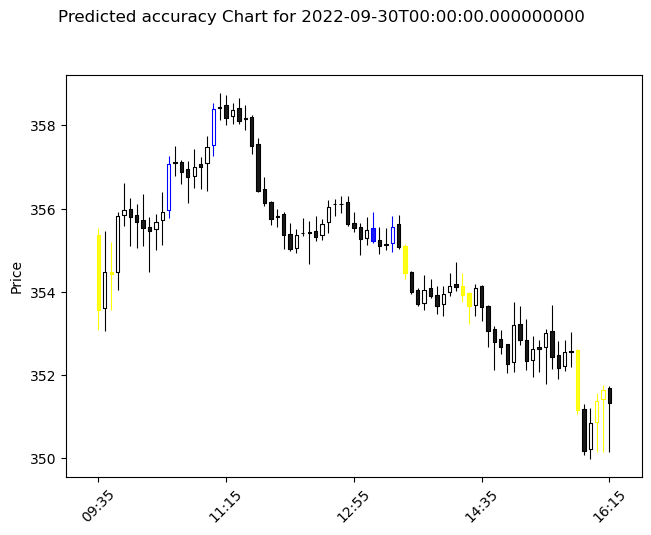

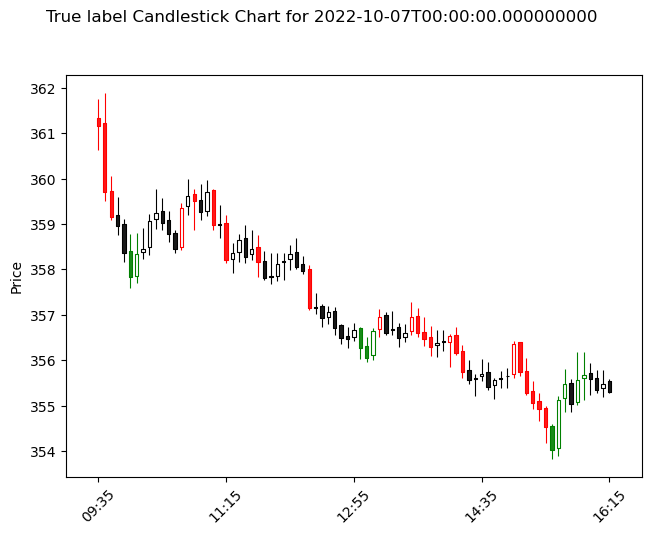

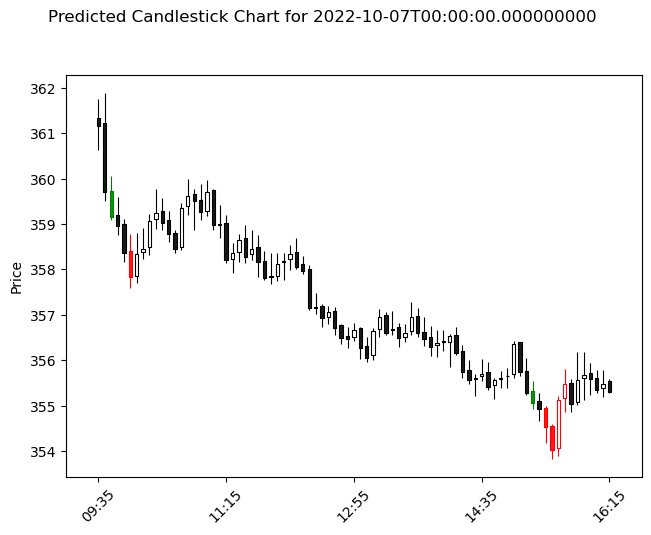

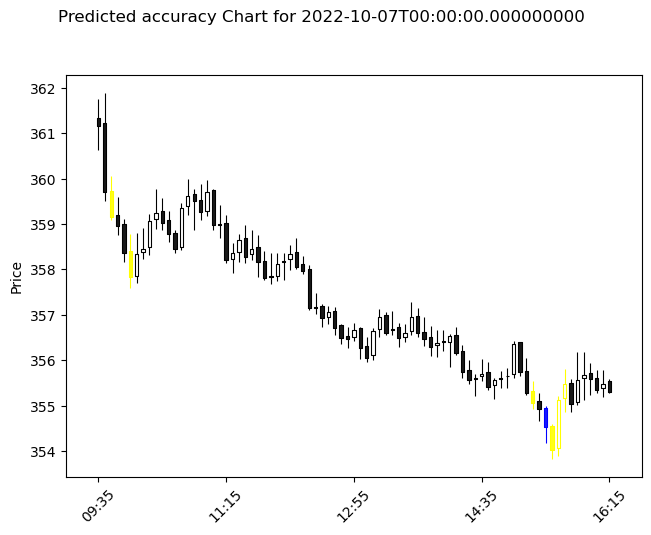

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np


# Iterate over each unique date to create separate plots
for unique_date in unique_dates:
    # Filter data for the current date
    daily_data = test_data[test_data['Date'] == unique_date]

    # Create figure and axes
    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    # Plot candlestick chart for true labels
    color_override = []
    for date, row in daily_data.iterrows():
        mc = mpf.make_marketcolors(up='white',down='k',
                                    edge='k',
                                    wick={'up':'k','down':'k'},
                                    volume='gray',
                                    ohlc='black')
        if row['label'] == 1 and row['highlight']:
            mc = mpf.make_marketcolors(up='white',down='green',
                                    edge='green',
                                    wick={'up':'green','down':'green'},
                                    volume='gray',
                                    ohlc='black')
        elif row['label'] == -1 and row['highlight']:
            mc = mpf.make_marketcolors(up='white',down='red',
                                    edge='red',
                                    wick={'up':'red','down':'red'},
                                    volume='gray',
                                    ohlc='black')
        color_override.append(mc)
    style  = mpf.make_mpf_style(marketcolors=mc)    
    # Plot ATR
    mpf.plot(daily_data, style=style, type='candle', marketcolor_overrides=color_override,title=f'True label Candlestick Chart for {unique_date}')

    # Plot candlestick chart for predicted labels
    color_override = []
    for date, row in daily_data.iterrows():
        mc = mpf.make_marketcolors(up='white',down='k',
                                    edge='k',
                                    wick={'up':'k','down':'k'},
                                    volume='gray',
                                    ohlc='black')
        if row['Predicted_Label'] == 1 and row['highlight']:
            mc = mpf.make_marketcolors(up='white',down='green',
                                    edge='green',
                                    wick={'up':'green','down':'green'},
                                    volume='gray',
                                    ohlc='black')
        elif row['Predicted_Label'] == -1 and row['highlight']:
            mc = mpf.make_marketcolors(up='white',down='red',
                                    edge='red',
                                    wick={'up':'red','down':'red'},
                                    volume='gray',
                                    ohlc='black')
            
        color_override.append(mc)
    style  = mpf.make_mpf_style(marketcolors=mc)    
    # Plot ATR
    mpf.plot(daily_data, style=style, type='candle', marketcolor_overrides=color_override,title=f'Predicted Candlestick Chart for {unique_date}')
    
    
    
    color_override = []
    for date, row in daily_data.iterrows():
        mc = mpf.make_marketcolors(up='white',down='k',
                                    edge='k',
                                    wick={'up':'k','down':'k'},
                                    volume='gray',
                                    ohlc='black')
        if row['Predicted_Label'] == 1 or row['Predicted_Label'] == -1:
            if row['Predicted_Label'] == row['label'] and row['highlight']:
                mc = mpf.make_marketcolors(up='white',down='blue',
                                        edge='blue',
                                        wick={'up':'blue','down':'blue'},
                                        volume='gray',
                                        ohlc='black')
            elif row['Predicted_Label'] != row['label'] and row['highlight']:
                mc = mpf.make_marketcolors(up='white',down='yellow',
                                        edge='yellow',
                                        wick={'up':'yellow','down':'yellow'},
                                        volume='gray',
                                        ohlc='black')
            
        color_override.append(mc)
    style  = mpf.make_mpf_style(marketcolors=mc)    
    # Plot ATR
    mpf.plot(daily_data, style=style, type='candle', marketcolor_overrides=color_override,title=f'Predicted accuracy Chart for {unique_date}')